# Scenario
Create a model that will predict whether a airbnb will get a perfect 5.0 rating in San Diego California. The purpose of this model is for airbnb hosts to have a way to evaluate their rentals and make sure that they are meeting all of the criteria to get that perfect review.

<b> Airbnb consultancy business wants data analyzed. </b>

## Alternative Scenario: 
    - Airbnb is an industry disruptor. Many Hosts get a good deal of income from it. 
    - The goal of is to be a "5 Star Host" or "SuperHost". 
    - What can they do to get more 5 Star Ratings?
    - any particular features?

## Questions to Answer

1. How many units have a perfect rating?
2. How long have they had perfect rating?
3. How many reviews should the unit have to be considered? (ie, one 5.0 isn't enough)
4. What review metrics have the most impact?
5. What house factors have the most impact?
6. Relationship between price and rating?

## Understanding AirBnb

### Importance of 5 Star Rating

### Importance of Superhost

## Evaluation Metrics

<b><u>What I will be looking for in my models:</b></u>
- 1. <b>High Precision Score:</b> I want to make sure that I am identifying as many airbnb units that meet my target criteria as possible. I will keep this in balance by checking F1 Score.
- 2. <b>Good F1 Score:</b> While I am ultimately not concerned with Recall , a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer is within my target would have perfect Recall, but would be useless).
- 3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).
- 4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. 

<b><u>That said, here is the scale that I will use to evaluate my models:</b></u>

- <b>.69 or less:</b> Model performs only slightly better than guessing and is worthless for my analysis.
- <b>.70 - .79:</b> Model still isn't performing very well, but is at minimum acceptable levels.
- <b>.80 - .89:</b> Model is performing fairly well. My goal is to be in this range or better.
- <b>.90 - .99:</b> Model is performing very well. I would be very happy to have a final model in this range.

## Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np


In [2]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

## Listing_DF: Baseline DF with many columns

In [3]:
listing_df = pd.read_csv('listings.csv.gz')

In [4]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

### Fixing Price
- Price is currently a string. I need to strip out the extra characters and convert the datatype to Float so that I can better utilize the data.

In [5]:
listing_df['price']

0         $60.00
1        $282.00
2        $348.00
3        $368.00
4        $264.00
          ...   
10930    $228.00
10931    $168.00
10932    $500.00
10933     $67.00
10934     $88.00
Name: price, Length: 10935, dtype: object

In [6]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [7]:
listing_df['price']

0         60.0
1        282.0
2        348.0
3        368.0
4        264.0
         ...  
10930    228.0
10931    168.0
10932    500.0
10933     67.0
10934     88.0
Name: price, Length: 10935, dtype: float64

## Base DF
- I am slicing out the columns that will be useful for analyzing and modeling the data, to make the dataframe more manageable.

In [8]:
base_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value','accommodates',
                              'bedrooms', 'beds', 'instant_bookable',
                             'property_type', 'room_type', 'amenities', 'availability_365', 'availability_30',
                             'availability_90',
                             'host_id', 'calculated_host_listings_count', 'host_response_time', 'host_response_rate',
                             'host_is_superhost']]

In [9]:
df = base_df

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

### Host Info

In [11]:
df['host_response_time'].value_counts()

within an hour        7911
within a few hours    1327
within a day           590
a few days or more     285
Name: host_response_time, dtype: int64

In [12]:
df['host_response_rate'].value_counts().head()

100%    7229
97%      354
98%      349
91%      279
99%      261
Name: host_response_rate, dtype: int64

In [13]:
df['instant_bookable'].value_counts()

f    5912
t    5023
Name: instant_bookable, dtype: int64

In [14]:
df['host_id'].value_counts()

88168913     219
429429981    163
3017970      119
226804666     85
147276739     76
            ... 
113819301      1
205127323      1
14767766       1
5039760        1
20667939       1
Name: host_id, Length: 5034, dtype: int64

### New Feature: Host Listings 5+
- Creating a new feature that tells whether a host has many listings.

In [15]:
df['calculated_host_listings_count'].value_counts().head(4)

1    3568
2    1468
3     816
4     540
Name: calculated_host_listings_count, dtype: int64

In [16]:
df['host_listings_5+'] =df['calculated_host_listings_count'] >= 5

In [17]:
df['host_listings_5+'].value_counts()

False    6392
True     4543
Name: host_listings_5+, dtype: int64

6392 records (out of 10935) are for hosts with 4 or less listings. (58%) This feature will help analyze whether having a large number of listings has any effect on having a 5 Star rating.

### New Feature: Capacity Ranges

In [18]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [19]:
df['capacity_couple'] = df['accommodates'] <= 2
df['capacity_family'] = df['accommodates'] == range(3 , 4)
df['capacity_large'] = df['accommodates'] <= 5

In [20]:
print((df['capacity_couple'] == True).sum())

3323


In [21]:
print((df['capacity_family'] == True).sum())

757


In [22]:
print((df['capacity_large'] == True).sum())

7033


### New Feature: Bedroom Ranges

In [23]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

46% of the units that I have bedroom data for are 1 bedroom. I will create a feature that groups units as either 1 bedroom or 2 or more.

In [24]:
df['bedrooms_1'] = df['bedrooms'] <= 1
df['bedrooms_2+'] = df['bedrooms'] >= 2

In [25]:
df['bedrooms_1'].value_counts()

False    6314
True     4621
Name: bedrooms_1, dtype: int64

### New Feature: Booked
- Booked: For the next 30 days, at least 25 days have already been booked.

In [26]:
df['availability_30'].value_counts()

0     2939
5      450
1      447
2      434
4      432
3      400
30     394
6      383
8      333
9      308
7      297
29     275
11     259
10     258
23     244
13     240
12     239
21     238
14     218
16     208
15     206
20     202
26     193
19     192
17     191
18     187
27     180
22     163
25     158
28     141
24     126
Name: availability_30, dtype: int64

In [27]:
df['booked'] = df['availability_30'] == 0

Creating a feature that determines whether a unit is completely booked for the next 30 days. 

In [28]:
df['booked'].value_counts()

False    7996
True     2939
Name: booked, dtype: int64

In [29]:
df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

### New Feature: Host Response Rate 100
- Feature that determines whether a host has a perfect response rate.

In [31]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', ' ')
df['host_response_rate']  = df['host_response_rate'].astype('float')
df['host_response_100'] = df['host_response_rate'] == 100.0
df['host_response_100'].value_counts()

True     7229
False    3706
Name: host_response_100, dtype: int64

### Fixing Host is Superhost

Feature is currently a string instead of a bool. Correcting that so I can classify whether a host is a superhost or not.

In [32]:
df['host_is_superhost'] = df['host_is_superhost'].str.replace('f', 'False')
df['host_is_superhost'] = df['host_is_superhost'].str.replace('t', 'True')
df['superhost'] = df['host_is_superhost'] == 'True'
df['superhost'].value_counts()

False    6095
True     4840
Name: superhost, dtype: int64

### Fixing Instant Bookable
- Feature is currently a string instead of a bool. Correcting that so I can classify whether the unit can be instantly booked or not.

In [33]:
df['instant_bookable'] = df['instant_bookable'].str.replace('f', 'False')
df['instant_bookable'] = df['instant_bookable'].str.replace('t', 'True')
df['instant_bookable'] = df['instant_bookable'] == 'True'
df['instant_bookable'].value_counts()

False    5912
True     5023
Name: instant_bookable, dtype: int64

### New Feature: 5-Star Units
- this is my target feature. It classifies whether a unit has a 5.0 overall rating or not.

In [34]:
(df['review_scores_rating'] == 5.00).sum()

2054

In [35]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. If I drop them, I will lose 14% of my data.

In [36]:
nulls = df[df['review_scores_rating'].isna()]

In [37]:
nulls.head(3)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_is_superhost,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1,bedrooms_2+,booked,host_response_100,superhost
12,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,4.0,...,False,False,False,False,False,False,True,False,False,False
23,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.0,...,False,True,False,False,True,True,False,False,False,False
70,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,False,False,True,False,True,True,False,False,True,False


nulls appear to have no ratings. Let's drop them for now.

In [38]:
df = df.dropna()

<b> 8385 Records are left after dropping null values </b>

In [39]:
df.head(2)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_is_superhost,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1,bedrooms_2+,booked,host_response_100,superhost
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,False,True,False,True,True,False,True,True,False
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,True,False,False,False,False,False,True,False,True,True


In [40]:
df['5_star'] = df['review_scores_rating'] >= 4.8

In [41]:
df['5_star'].value_counts()

True     4918
False    2892
Name: 5_star, dtype: int64

### 5 Star Analysis:
- Out of 7810 records:
-- 22.5% had a perfect rating
-- 77.5% did not have a perfect rating

### Creating Classifier Column

In [42]:
#df['rating_5'] = df['review_scores_rating'] == 5.00
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00
df['communication_5'] = df['review_scores_communication'] == 5.00

### Future Work: Analyze how much more likely a 5.0 rated rental is to be successful than a non-5.0 rated rental

In [43]:
df['location_5'].value_counts()

False    5434
True     2376
Name: location_5, dtype: int64

### Creating Binned Price Categories

<b> It is difficult to analyze price because it is relative. A low priced home that sleeps 10 people still costs more than a high priced home that sleeps 2 </b>

In [44]:
#df['price'].describe()

In [45]:
#df['price_high'] = df['price'] >= 350
#df['price_low'] = df['price'] <= 120

In [46]:
#df['price_high'] = df['price'] >= 200
#df['price_low'] = df['price'] < 200

In [47]:
#df

### Stripped Rating: For Visualizations

In [48]:
df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [49]:
df['stripped_rating']

0        5
1        4
2        4
3        4
4        5
        ..
10929    4
10930    4
10931    4
10932    5
10933    4
Name: stripped_rating, Length: 7810, dtype: object

In [50]:
df = df.sort_values('stripped_rating', ascending=False)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 5239
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   78

## Attempting visualization

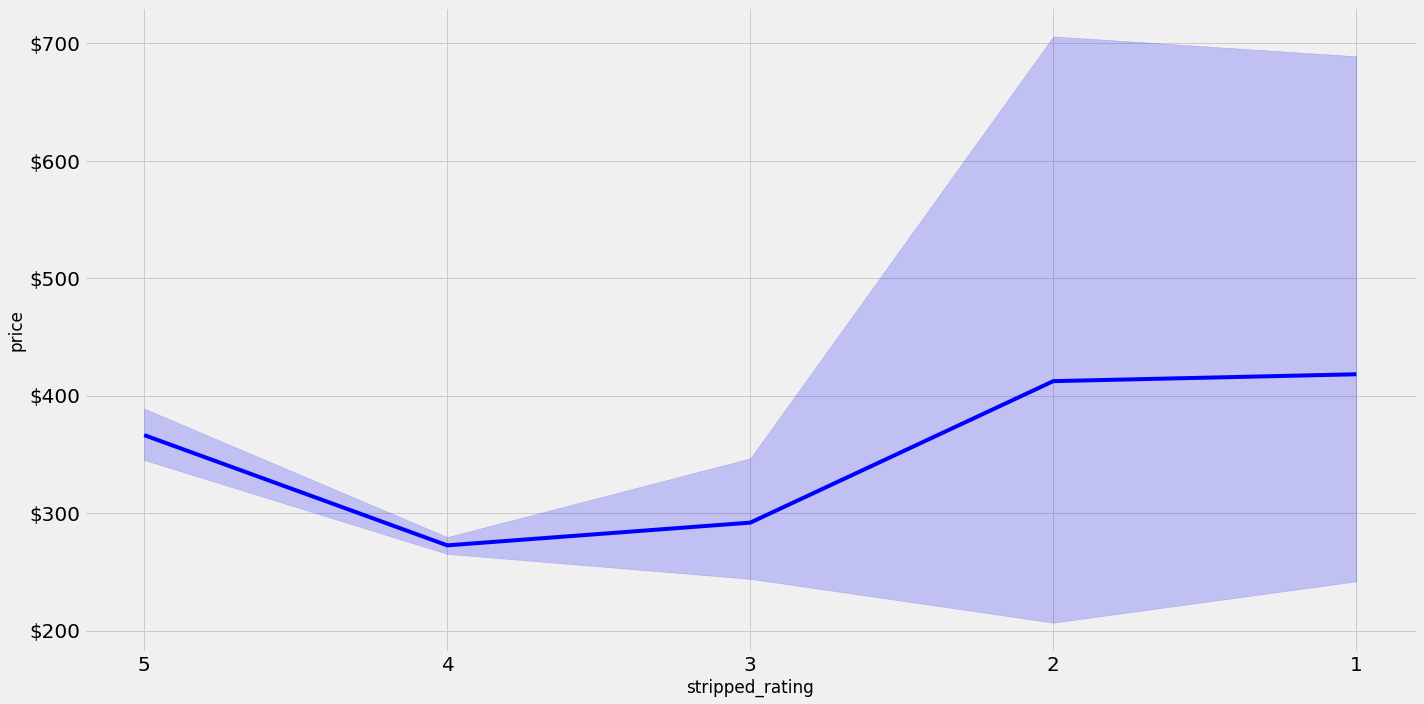

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [53]:
scatter_df = df[df['review_scores_rating'] >= 4.0]

In [54]:
scatter_mean = scatter_df['price'].mean()
scatter_mean

293.9845347313237

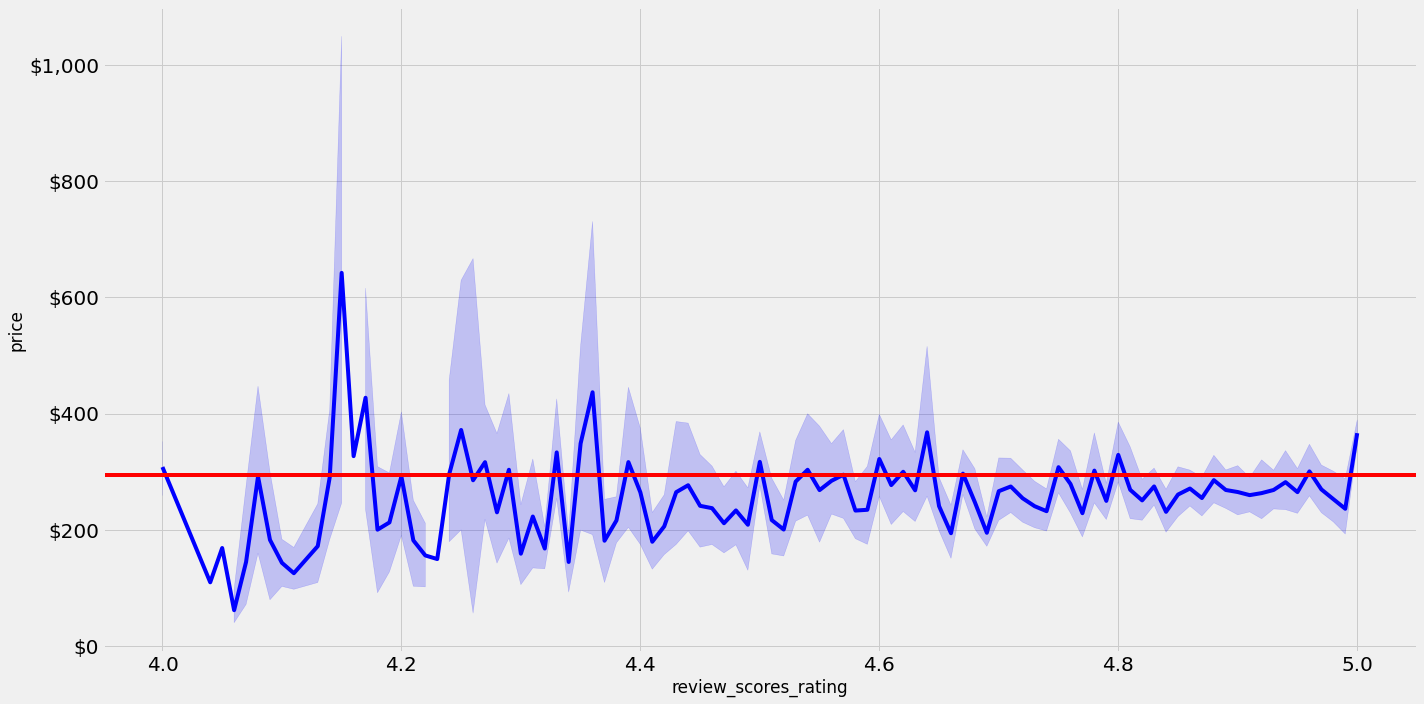

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [56]:
df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_response_100,superhost,5_star,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,stripped_rating
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,...,True,False,True,True,True,True,False,True,True,5


In [57]:
df.sort_values('5_star', ascending=False).head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_response_100,superhost,5_star,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,stripped_rating
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,True,False,True,True,True,True,False,True,True,5
7277,177.0,4.92,4.97,4.95,4.82,4.98,4.95,4.87,3,1.0,...,True,True,True,False,False,False,False,False,False,4
7160,1261.0,4.86,4.73,4.77,4.95,4.95,4.91,4.45,12,4.0,...,False,False,True,False,False,False,False,False,False,4
7161,541.0,4.83,5.00,4.67,4.17,5.00,5.00,4.83,16,6.0,...,False,False,True,True,False,False,True,False,True,4
4743,43.0,4.83,4.67,4.58,5.00,5.00,5.00,4.75,1,1.0,...,True,True,True,False,False,True,True,False,True,4


### Creating Analysis_df

In [58]:
analysis_df = df.copy()

## EDA

In [59]:
analysis_df['5_star'].value_counts()

True     4918
False    2892
Name: 5_star, dtype: int64

<b>Analysis: Out of the 7810 Records in this dataset, 22.1% have a 5 Star Overall Rating </b>

## Modelling

### Getting Data Ready for Modelling

In [60]:
#cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
#feature_df = df.loc[:, cont_features]
#feature_df.head()

In [61]:
#test_df = df.drop(cont_features, axis=1)

In [62]:
#test_df

In [63]:
#feature_df.drop(['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',
#                 'review_scores_checkin', 'review_scores_communication','review_scores_value',
#                 'review_scores_location', 'accommodates', 'bedrooms',
#                 'beds'], axis=1, inplace=True#)

In [64]:
#feature_df.drop(['review_scores_location'], axis=1, inplace=True)

In [65]:
#feature_df.head()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 5239
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   78

#### One Hot Encoding

In [67]:
need_to_encode = df[['5_star', 'accuracy_5', 'cleanliness_5', 'checkin_5', 'location_5', 'value_5',
                     'communication_5', 'room_type',  'bedrooms_1', 'bedrooms_2+', 'booked', 
                     'instant_bookable', 'capacity_couple', 'capacity_family', 'capacity_large',
                     'host_listings_5+', 'superhost', 'host_response_100', 'host_response_time']]
                     
                     # 'price_high', 'price_low',
                    #'capacity_1-4', 'capacity_5+',
                    # 'capacity_-2','capacity_-4', 'capacity_-6', 'capacity_-10', 'capacity_11+',
                    #'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
                    
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,5_star_False,5_star_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,host_listings_5+_False,host_listings_5+_True,superhost_False,superhost_True,host_response_100_False,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [68]:
# Combining everything together
#cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
#cleaned_df.head(2)

In [69]:
cleaned_df = ohe_df

In [70]:
cleaned_df

,5_star_False,5_star_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,host_listings_5+_False,host_listings_5+_True,superhost_False,superhost_True,host_response_100_False,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7805,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7806,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7807,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7808,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Dropping One Value for Categoricals

In [71]:
cleaned_df.drop(['5_star_False', 'accuracy_5_False', 'cleanliness_5_False', 'checkin_5_False',
                              'location_5_False','value_5_False', 'bedrooms_1_False', 'bedrooms_2+_False',
                              'capacity_couple_False', 'capacity_family_False', 'capacity_large_False',
                              'instant_bookable_False', 'booked_False', 'room_type_Hotel room',
                              'host_response_100_False', 'communication_5_False', 'superhost_False',
                              'host_listings_5+_False'], axis=1, inplace=True)
                              
                              
                              #'price_high_False', 'price_low_False',
                           # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                             
                            #'capacity_1-4_False', 'capacity_5+_False',
                             # 'capacity_-2_False','capacity_-4_False', 'capacity_-6_False',
                             # 'capacity_-10_False', 'capacity_11+_False',
                            

### 5_Star and Low Rated DFs Created

In [72]:
five_star_df = cleaned_df[cleaned_df['5_star_True'] == 1]
low_rated_df = cleaned_df[cleaned_df['5_star_True'] == 0]

In [73]:
five_star_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,4918.0,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,...,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000
mean,1.0,0.366612,0.326962,0.455063,0.377389,0.230785,0.473973,0.822489,0.172631,0.004270,...,0.291379,0.058357,0.615087,0.321269,0.660228,0.786702,0.018097,0.061610,0.125661,0.794632
std,0.0,0.481928,0.469151,0.498027,0.484783,0.421378,0.499373,0.382140,0.377967,0.065212,...,0.454444,0.234441,0.486624,0.467011,0.473680,0.409678,0.133315,0.240471,0.331500,0.404011
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
low_rated_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,2892.0,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,...,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000
mean,0.0,0.069502,0.076418,0.168741,0.179806,0.033195,0.153527,0.844398,0.142462,0.012448,...,0.198824,0.054633,0.562932,0.561549,0.260028,0.640387,0.018326,0.049447,0.129668,0.802559
std,0.0,0.254350,0.265711,0.374588,0.384092,0.179176,0.360557,0.362540,0.349584,0.110894,...,0.399185,0.227303,0.496110,0.496283,0.438725,0.479970,0.134152,0.216836,0.335996,0.398137
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Proof Of Concept: 5 Star Units Contrasted with Low Rated Units

In [75]:
five_star_analysis_df = cleaned_df.copy()

In [76]:
five_star_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5_star_True                            7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   room_type_Entire home/apt              7810 non-null   float64
 8   room_type_Private room                 7810 non-null   float64
 9   room_type_Shared room                  7810 non-null   float64
 10  bedrooms_1_True                        7810 non-null   float64
 11  bedr

In [77]:
five_star_analysis_df.groupby('5_star_True').mean()

,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bedrooms_1_True,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
5_star_True,,,,,,,,,,,,,,,,,,,,,
0.0,0.069502,0.076418,0.168741,0.179806,0.033195,0.153527,0.844398,0.142462,0.012448,0.429806,...,0.198824,0.054633,0.562932,0.561549,0.260028,0.640387,0.018326,0.049447,0.129668,0.802559
1.0,0.366612,0.326962,0.455063,0.377389,0.230785,0.473973,0.822489,0.172631,0.004270,0.474990,...,0.291379,0.058357,0.615087,0.321269,0.660228,0.786702,0.018097,0.061610,0.125661,0.794632


In [78]:
#dropping the columns where there isn't a large contrast between 5_star and low_rated.
five_star_analysis_df.drop(['room_type_Entire home/apt', 'room_type_Private room',
                            'room_type_Shared room', 'bedrooms_1_True',
                            'capacity_couple_True', 'capacity_family_True', 'capacity_large_True',
                             'host_response_100_True'], axis=1, inplace=True)

In [79]:
five_star_analysis_df.groupby('5_star_True').sum()

,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,bedrooms_2+_True,booked_True,instant_bookable_True,host_listings_5+_True,superhost_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
5_star_True,,,,,,,,,,,,,,,
0.0,201.0,221.0,488.0,520.0,96.0,444.0,1649.0,592.0,1642.0,1624.0,752.0,53.0,143.0,375.0,2321.0
1.0,1803.0,1608.0,2238.0,1856.0,1135.0,2331.0,2582.0,1171.0,2054.0,1580.0,3247.0,89.0,303.0,618.0,3908.0


In [80]:
five_star_analysis_df.groupby('accuracy_5_True').mean()

,5_star_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,bedrooms_2+_True,booked_True,instant_bookable_True,host_listings_5+_True,superhost_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
accuracy_5_True,,,,,,,,,,,,,,,
0.0,0.536514,0.084395,0.191182,0.162418,0.028763,0.189804,0.535481,0.200654,0.496900,0.432656,0.538581,0.014468,0.050293,0.115742,0.819497
1.0,0.899701,0.668164,0.806387,0.715070,0.530938,0.834830,0.559880,0.298403,0.404691,0.345309,0.435130,0.028942,0.076846,0.160180,0.734032


In [81]:
#cleaned_df.info()

In [82]:
#dropping redundant columns
#cleaned_df.drop(['host_response_time_a few days or more', 'room_type_Private room', 'room_type_Shared room',
#               'capacity_family_True', 'bedrooms_3+_True'], axis=1, inplace=True)

In [83]:
#cleaned_df.drop(['bedrooms_3+_True'], axis=1, inplace=True)

In [84]:
#cleaned_df.info()

#### Dealing with Class Imbalance

- Rentals without at 5.0 rating are at a rate of 3.4 to 1.
- <b> Solution </b>
    - Always use class weight parameter in Decision Tree Classifier
    - Always stratify Train Test Split.
    - Add SMOTE to Training Sets.

In [85]:
#cleaned_df['rating_5_True']

In [86]:
cleaned_df.isna().sum()

5_star_True                              0
accuracy_5_True                          0
cleanliness_5_True                       0
checkin_5_True                           0
location_5_True                          0
value_5_True                             0
communication_5_True                     0
room_type_Entire home/apt                0
room_type_Private room                   0
room_type_Shared room                    0
bedrooms_1_True                          0
bedrooms_2+_True                         0
booked_True                              0
instant_bookable_True                    0
capacity_couple_True                     0
capacity_family_True                     0
capacity_large_True                      0
host_listings_5+_True                    0
superhost_True                           0
host_response_100_True                   0
host_response_time_a few days or more    0
host_response_time_within a day          0
host_response_time_within a few hours    0
host_respon

In [87]:
#cleaned_df = cleaned_df.dropna()
#top_rated_df = top_rated_df.dropna()
#low_rated_df = low_rated_df.dropna()

In [88]:
#top_rated_df.isna().sum()

In [89]:
#cleaned_df.info()

In [90]:
#cleaned_df.isna().sum()

In [91]:
#cleaned_df.drop(['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price'], axis=1, inplace=True)

In [92]:
#dropping accuracy to see what the feature importances are
#cleaned_df.drop(['accuracy_5_True'], axis=1, inplace=True)

In [93]:
#dropping rating_5 and searching for accuracy as the target
#cleaned_df.drop(['rating_5_True'], axis=1, inplace=True)
#top_rated_df.drop(['rating_5_True'], axis=1, inplace=True)
#low_rated_df.drop(['rating_5_True'], axis=1, inplace=True)

In [94]:
# dropping price_high as it is redundant
# price_low means that the listing is below the mean avg price
#cleaned_df.drop(['price_high_True'], axis=1, inplace=True)
#top_rated_df.drop(['price_high_True'], axis=1, inplace=True)
#low_rated_df.drop(['price_high_True'], axis=1, inplace=True)

In [95]:
#booked_df = cleaned_df[cleaned_df['booked_True'] == 1]
#booked_df.head()

In [96]:
#booked_df.mean()

In [97]:
#cleaned_df.head(1)

In [98]:
#top_rated_df.describe()

In [99]:
#new_df = top_rated_df[['checkin_5_True', 'location_5_True', 'price_low_True', 'capacity_5+_True',
#                    'instant_bookable_t', 'booked_True']]

In [100]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5_star_True                            7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   room_type_Entire home/apt              7810 non-null   float64
 8   room_type_Private room                 7810 non-null   float64
 9   room_type_Shared room                  7810 non-null   float64
 10  bedrooms_1_True                        7810 non-null   float64
 11  bedr

In [101]:
### dropping unimportant features

#cleaned_df.drop(['bedrooms_1_True', 'bedrooms_2+_True',
                 #'capacity_couple_True', 'capacity_family_True', 'capacity_large_True',
 #                'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room',
 #                'host_response_time_a few days or more', 'host_response_time_within a day',
 #                 'host_response_time_within a few hours'], axis=1)

In [102]:
cleaned_df.head()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [103]:
review_df = cleaned_df[['5_star_True', 'accuracy_5_True', 'cleanliness_5_True', 'checkin_5_True',
                       'location_5_True', 'value_5_True', 'communication_5_True']]
review_df

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
7805,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7806,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7807,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7808,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
high_listing_df = cleaned_df[cleaned_df['host_listings_5+_True'] == True]

In [105]:
high_listing_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,...,3204.000000,3204.000000,3204.000000,3204.0,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000
mean,0.493134,0.215980,0.212235,0.294632,0.323346,0.130462,0.295880,0.902934,0.084582,0.011860,...,0.142010,0.042759,0.488140,1.0,0.429463,0.582709,0.012484,0.019351,0.100499,0.867665
std,0.500031,0.411565,0.408954,0.455948,0.467826,0.336864,0.456509,0.296094,0.278302,0.108274,...,0.349115,0.202345,0.499937,0.0,0.495077,0.493189,0.111051,0.137776,0.300712,0.338907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <b>Train Test Split</b>

In [106]:
balanced_df = cleaned_df.copy()

#balanced_df = high_listing_df.copy()
#balanced_df = review_df.copy()
#balanced_df = new_df.copy()

#balanced_df.drop(['accuracy_5_True', 'communication_5_True', 'cleanliness_5_True', 'checkin_5_True' ], axis=1, inplace=True)

X = balanced_df.drop(['5_star_True'], axis=1)
y = balanced_df['5_star_True']
#X = balanced_df.drop(['booked_True'], axis=1)
#y = balanced_df['booked_True']
#X = balanced_df.drop(['accuracy_5_True'], axis=1)
#y = balanced_df['accuracy_5_True']
#X = balanced_df.drop(['communication_5_True'], axis=1)
#y = balanced_df['communication_5_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

In [ ]:
#balanced_df['accuracy_5_True'].value_counts()

### Metrics Function

In [107]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    #clf_rcl = recall_score(y_test, y_pred) * 100
    #print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    clf_cv_score = np.mean(cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10))
    print('Cross Validation Score is :{0}'.format(round(clf_cv_score, 3)))

### Choosing Evaluation Metrics
- My goal is to predict whether a person will get a perfect 5.0 Airbnb rating.
- Which is worse?
    - Model predicts that someone has a perfect rating, but they actually don't? (more false Positives)
    - Model predicts that someone does not have a perfect rating, but they actually do? (more false negatives)

<b> Decision </b>
- I want false Positives to be as low as possible.
- If my model says that a property will have a 5.0 score, I want it to be a near guarantee.
- If it misses some that will still get a 5.0 score that is fine.
- <b>Therefore, I am most concerned with Precision, balanced out by F1 score.</b>

In [108]:
X.describe()

,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bedrooms_1_True,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,...,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000,7810.000000
mean,0.256594,0.234187,0.349040,0.304225,0.157618,0.355314,0.830602,0.161460,0.007298,0.458259,...,0.257106,0.056978,0.595775,0.410243,0.512036,0.732522,0.018182,0.057106,0.127145,0.797567
std,0.436781,0.423517,0.476697,0.460108,0.364406,0.478639,0.375127,0.367978,0.085123,0.498287,...,0.437066,0.231816,0.490773,0.491909,0.499887,0.442672,0.133617,0.232060,0.333156,0.401839
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline Decision Tree

In [109]:
#w/out SMOTE
dt0 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt0.fit(X_train, y_train)
dt0_y_pred = dt0.predict(X_test)
get_metrics(dt0, dt0_y_pred)

Precision is :81.11401218450827
F1 Score is :78.35224884405213
ROC AUC is :0.73
Cross Validation Score is :0.783


In [110]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)
get_metrics(dt1, dt1_y_pred)

Precision is :81.08108108108108
F1 Score is :78.2498948254102
ROC AUC is :0.73
Cross Validation Score is :0.783


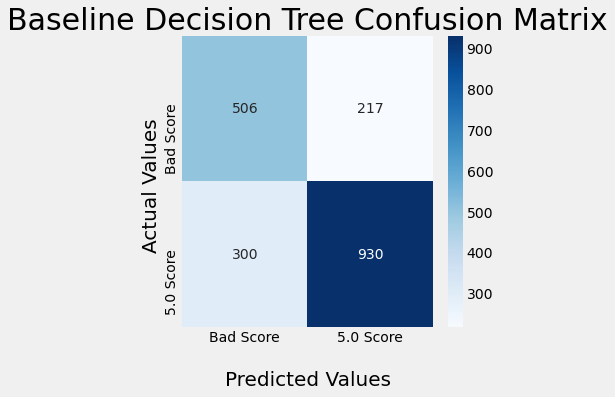

In [111]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [112]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [114]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

## Decision Tree 2

In [115]:
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2,
                             min_samples_leaf=2, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)
get_metrics(dt2, dt2_y_pred)

Precision is :81.86714542190305
F1 Score is :77.81569965870307
ROC AUC is :0.73
Cross Validation Score is :0.789


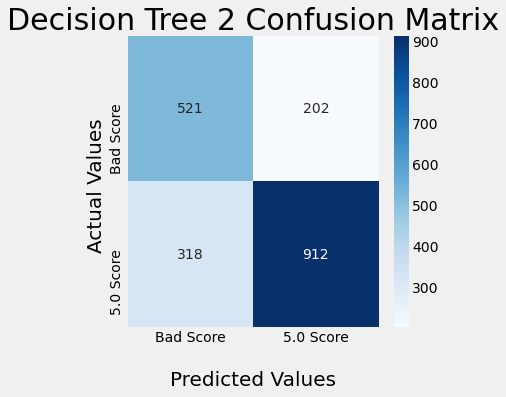

In [116]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [117]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)
get_metrics(rf1_clf, rf1_y_pred)

Precision is :81.27009646302251
F1 Score is :81.72999191592562
ROC AUC is :0.75
Cross Validation Score is :0.81


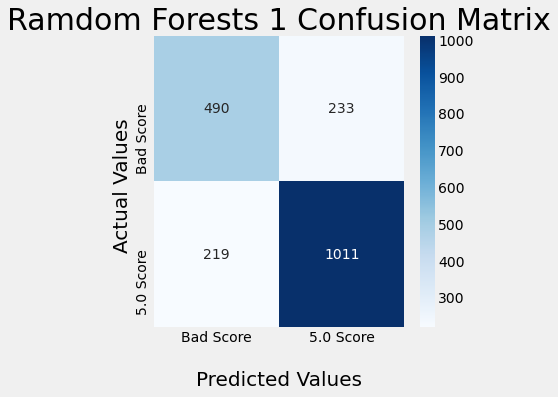

In [118]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch CV

In [119]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [120]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}


## Random Forests 2

In [121]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 10, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :84.60661345496008
F1 Score is :70.43189368770764
ROC AUC is :0.71
Cross Validation Score is :0.768


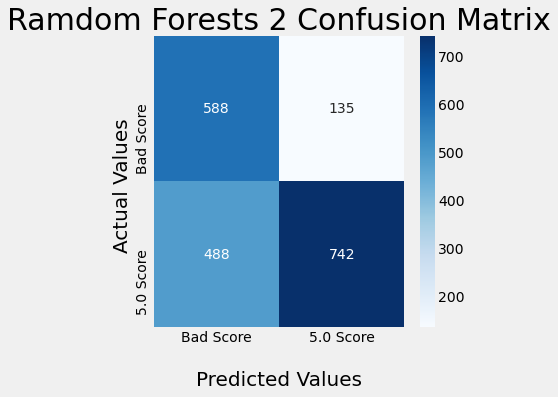

In [122]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost Model

In [123]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)
get_metrics(xg1, xg1_y_pred)

Precision is :81.9870759289176
F1 Score is :82.25283630470017
ROC AUC is :0.76
Cross Validation Score is :0.813


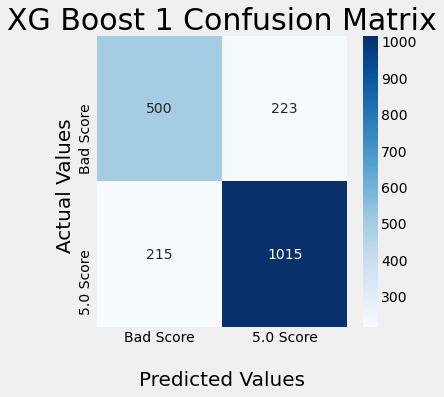

In [124]:
xg1_matrix = confusion_matrix(y_test, xg1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch

In [125]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [126]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='precision', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [127]:
xg2 = XGBClassifier(learning_rate= 0.1, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.7, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)
get_metrics(xg2, xg2_y_pred)

Precision is :82.43785084202085
F1 Score is :83.0036334275333
ROC AUC is :0.77
Cross Validation Score is :0.819


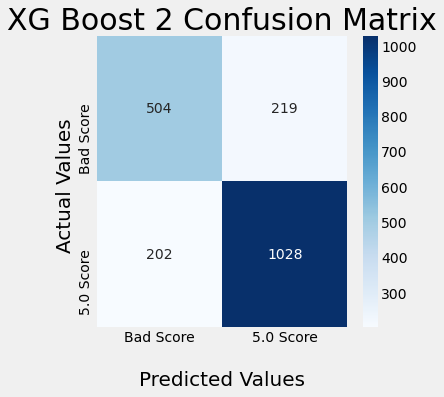

In [128]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FINAL MODEL = XG Boost 2

In [145]:
get_metrics(xg2, xg2_y_pred)
#get_metrics(rf1_clf, rf1_y_pred)

Precision is :82.43785084202085
F1 Score is :83.0036334275333
ROC AUC is :0.77
Cross Validation Score is :0.819


### Model Evaluation: (needs to be updated)
- <b> Precision: </b> This Model correctly picks whether a rental will receive a perfect 5 star overall AirBnb rating 79.4% of the time.
    - This is 30% better than random guessing.
    - The Final Model is also a slight improvement over the baseline model. (about 2% better)
- <b> Recall and F1 Score: </b> The Final Model's recall and F1 Scores are also slightly higher than the baseline model. The F1 Score indicates that the Precision is balanced well with Recall.
- <b> ROC AUC Score: </b> Shows the True Positive Rate vs. the False Postive Rate. My Random Forests 2 Model performed better on this metric, but also captured more false positives. I want to avoid false positives if at all possible, so I chose XG Boost 2 over Random Forests 2.
- <b> Cross Validation Score: </b> The high score shows that this model does a good job with new data that it was not trained on.


## Feature Importance

In [130]:
feature_names = list(X)
feature_names

['accuracy_5_True',
 'cleanliness_5_True',
 'checkin_5_True',
 'location_5_True',
 'value_5_True',
 'communication_5_True',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'bedrooms_1_True',
 'bedrooms_2+_True',
 'booked_True',
 'instant_bookable_True',
 'capacity_couple_True',
 'capacity_family_True',
 'capacity_large_True',
 'host_listings_5+_True',
 'superhost_True',
 'host_response_100_True',
 'host_response_time_a few days or more',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour']

In [131]:
xg2_importance = xg2.feature_importances_
xg2_importance

array([0.23405115, 0.03800882, 0.03160052, 0.02268194, 0.04470423,
       0.05903001, 0.01691316, 0.0163317 , 0.01013514, 0.01973078,
       0.        , 0.02108977, 0.02466543, 0.01890973, 0.01863959,
       0.01710171, 0.04320844, 0.27266788, 0.023692  , 0.0190742 ,
       0.01760642, 0.01568693, 0.01447041], dtype=float32)

In [132]:
#feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
17,superhost_True,0.272668
0,accuracy_5_True,0.234051
5,communication_5_True,0.059030
4,value_5_True,0.044704
16,host_listings_5+_True,0.043208
1,cleanliness_5_True,0.038009
2,checkin_5_True,0.031601
12,instant_bookable_True,0.024665
18,host_response_100_True,0.023692
3,location_5_True,0.022682


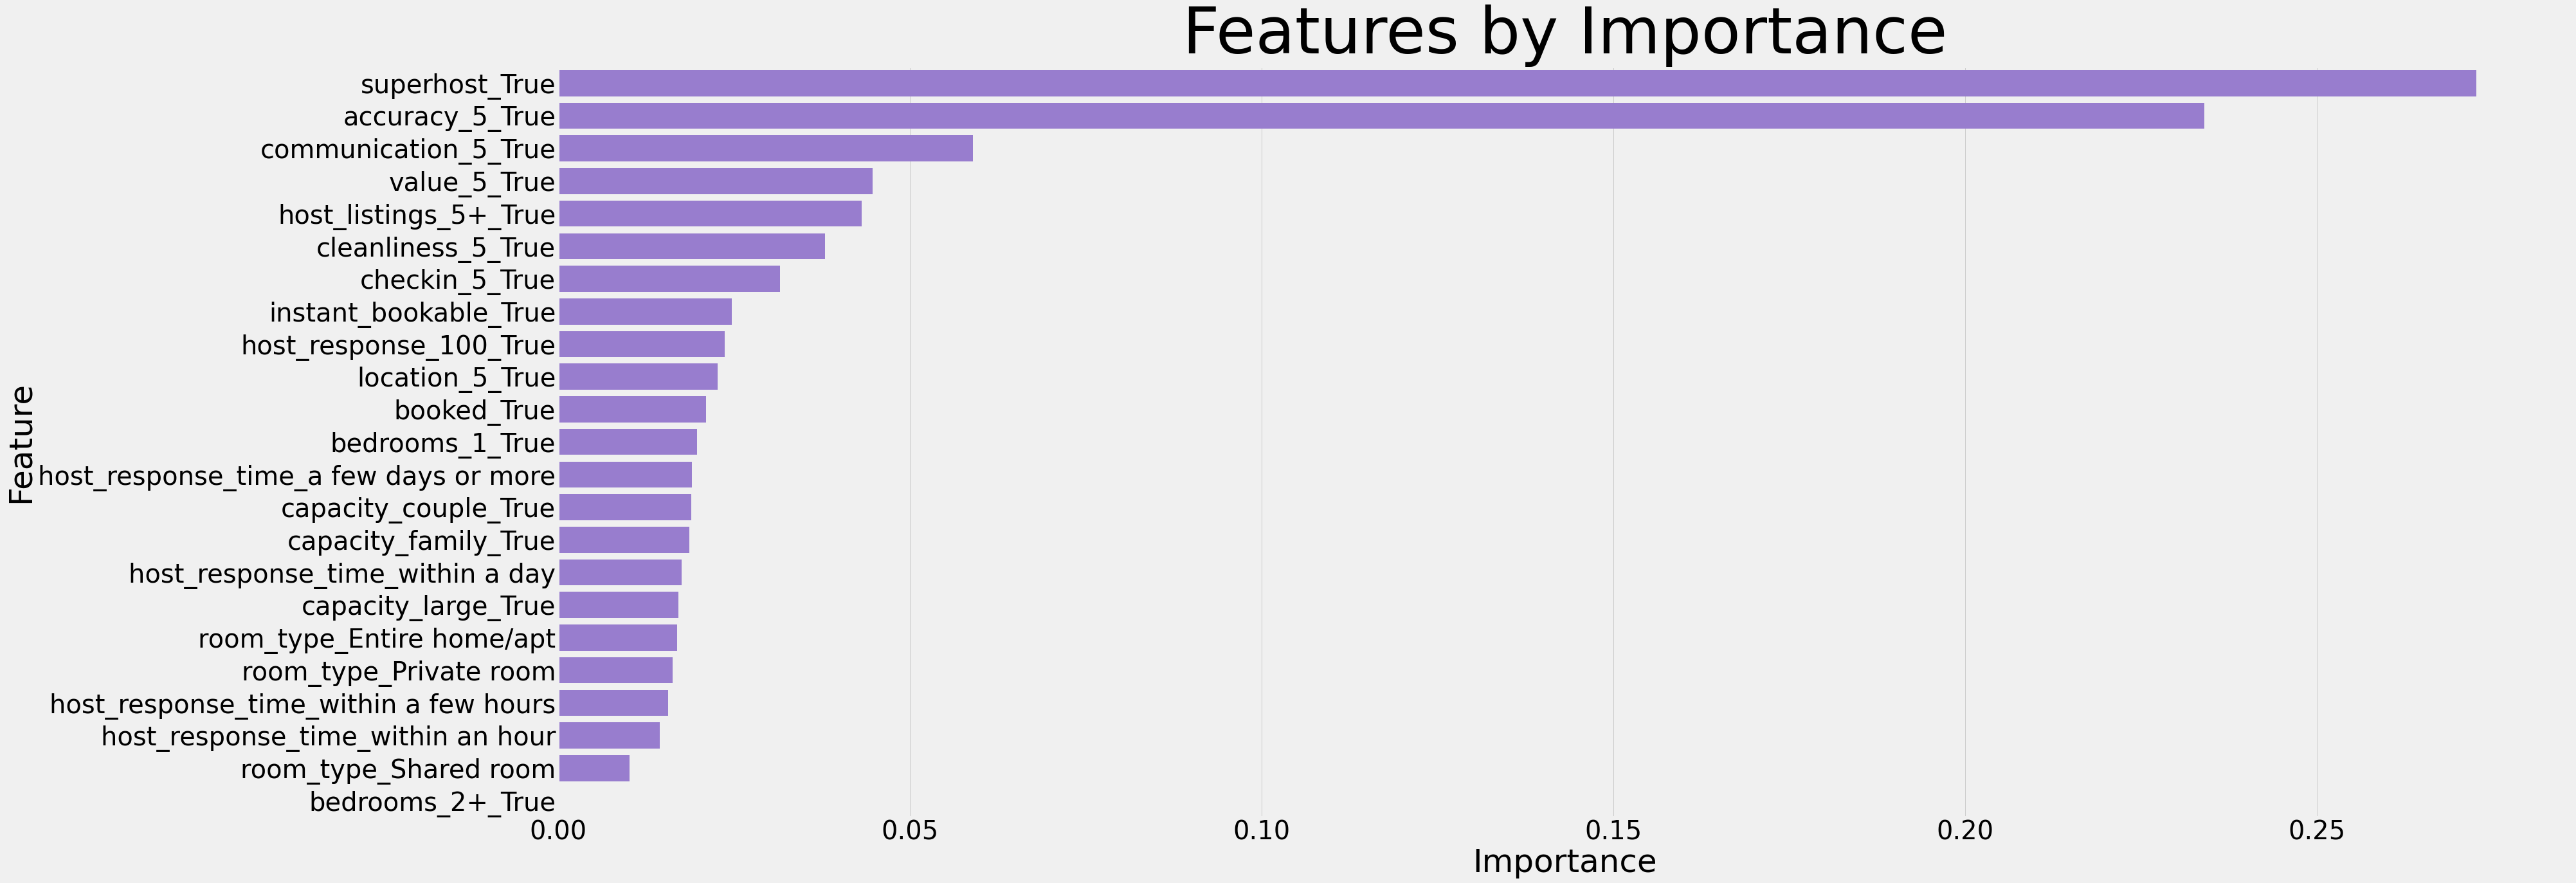

In [133]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

## <b>Review Metric DF (or Feature Analysis DF)</b>

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 5239
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   78

In [135]:
review_metrics = df[['5_star', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
                     'value_5', 'superhost', 'host_listings_5+', 'instant_bookable', 'booked', 
                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100',
                     'room_type', 'host_response_time','bedrooms_1']]

In [136]:
review_metrics.head(2)

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,room_type,host_response_time,bedrooms_1
0,True,True,True,True,True,False,True,False,False,True,True,True,False,True,True,Private room,within an hour,True
8389,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,Entire home/apt,within an hour,False


In [137]:
#review_metrics['instant_bookable'] = review_metrics['instant_bookable'].astype('bool')
#review_metrics['host_is_superhost'] = review_metrics['host_is_superhost'].astype('bool')

In [138]:
review_metrics['instant_bookable'].value_counts()

False    4114
True     3696
Name: instant_bookable, dtype: int64

## Looking at Accuracy a different way (6/13)

In [139]:
df['accuracy_5'].describe()

count      7810
unique        2
top       False
freq       5806
Name: accuracy_5, dtype: object

In [140]:
balanced_df['accuracy_5_True'].value_counts()

0.0    5806
1.0    2004
Name: accuracy_5_True, dtype: int64

In [141]:
balanced_df['5_star_True'].value_counts()

1.0    4918
0.0    2892
Name: 5_star_True, dtype: int64

In [142]:
cleaned_df.groupby('booked_True').sum()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
booked_True,,,,,,,,,,,,,,,,,,,,,
0.0,3747.0,1406.0,1312.0,1913.0,1730.0,847.0,1961.0,5130.0,863.0,49.0,...,1388.0,328.0,3427.0,2684.0,3153.0,4408.0,62.0,256.0,682.0,5047.0
1.0,1171.0,598.0,517.0,813.0,646.0,384.0,814.0,1357.0,398.0,8.0,...,620.0,117.0,1226.0,520.0,846.0,1313.0,80.0,190.0,311.0,1182.0


## Function get_stats( )

In [199]:
def get_stats(df):
    
    df_transposed = df.transpose()
    df_transposed = df_transposed.reset_index()
    df_transposed.rename(columns={'index': 'Metric'}, inplace=True)
    stats_df = df_transposed
    total = stats_df.apply(lambda x: x[False] + x[True], axis=1)
    stats_df['total'] = total
    #difference = stats_df.apply(lambda x: x[True] - x[False], axis=1)
    #stats_df['diff'] = difference
    #percent_difference = stats_df.apply(lambda x: x['diff'] / x['total'], axis=1)
    #stats_df['diff_percent'] = percent_difference
    true = stats_df.apply(lambda x: x[True] / x['total'], axis=1)
    stats_df['%_True'] = true*100
    false = stats_df.apply(lambda x: x[False] / x['total'], axis=1)
    stats_df['%_False'] = false*100
    delta = stats_df.apply(lambda x: x['%_True'] - x['%_False'], axis=1)
    stats_df['delta'] = delta
         
    return stats_df. sort_values('delta', ascending=False)

In [202]:
def plot_stats(df):
    
    fig, ax = plt.subplots(figsize=(50,20))
    p = sns.barplot(data=df.head(10), x='Metric', y='delta', color ='seagreen' );
    p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

    p.set_xlabel("Feature", fontsize = 50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    p.set_title("Difference Between Features ", fontsize = 100)
    plt.figsize=(30,20) 

    return plt.show();

In [148]:
review_metrics.describe()

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,room_type,host_response_time,bedrooms_1
count,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,4,2
top,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,Entire home/apt,within an hour,False
freq,4918,5806,5035,5981,5084,5434,6579,3999,4606,4114,6047,5802,7365,4653,5721,6487,6229,4231


### <b>Top Feature #1: SuperHost</b>

In [204]:
review_metrics['superhost'].value_counts()

True     3999
False    3811
Name: superhost, dtype: int64

In [205]:
superhost_metrics = review_metrics.groupby('superhost').sum()
superhost_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
superhost,,,,,,,,,,,,,,,
False,1671,1132,1394,1036,1432,1416,814,1828,1912,917,920,212,2200,2461,1662
True,3247,872,1381,793,1294,960,417,1376,1784,846,1088,233,2453,3260,1917


In [206]:
superhost_stats = get_stats(superhost_metrics)
superhost_stats

superhost,Metric,False,True,total,%_True,%_False,delta
0,5_star,1671,3247,4918,66.022773,33.977227,32.045547
13,host_response_100,2461,3260,5721,56.983045,43.016955,13.966090
10,capacity_couple,920,1088,2008,54.183267,45.816733,8.366534
14,bedrooms_1,1662,1917,3579,53.562448,46.437552,7.124895
12,capacity_large,2200,2453,4653,52.718676,47.281324,5.437352
11,capacity_family,212,233,445,52.359551,47.640449,4.719101
2,communication_5,1394,1381,2775,49.765766,50.234234,-0.468468
8,instant_bookable,1912,1784,3696,48.268398,51.731602,-3.463203
9,booked,917,846,1763,47.986387,52.013613,-4.027226
4,checkin_5,1432,1294,2726,47.468819,52.531181,-5.062362


<b>Analysis: </b>
- Clients that are superhosts are more likely to have a 5 Star Overall Rating. This isn't surprising as that is one of the requirements for being a superhost.
- They are also more likely to have a strong response rate. 
- However, their communication scores are midling, and most importantly, they have a significantly lower likelyhood of getting a perfect value score.

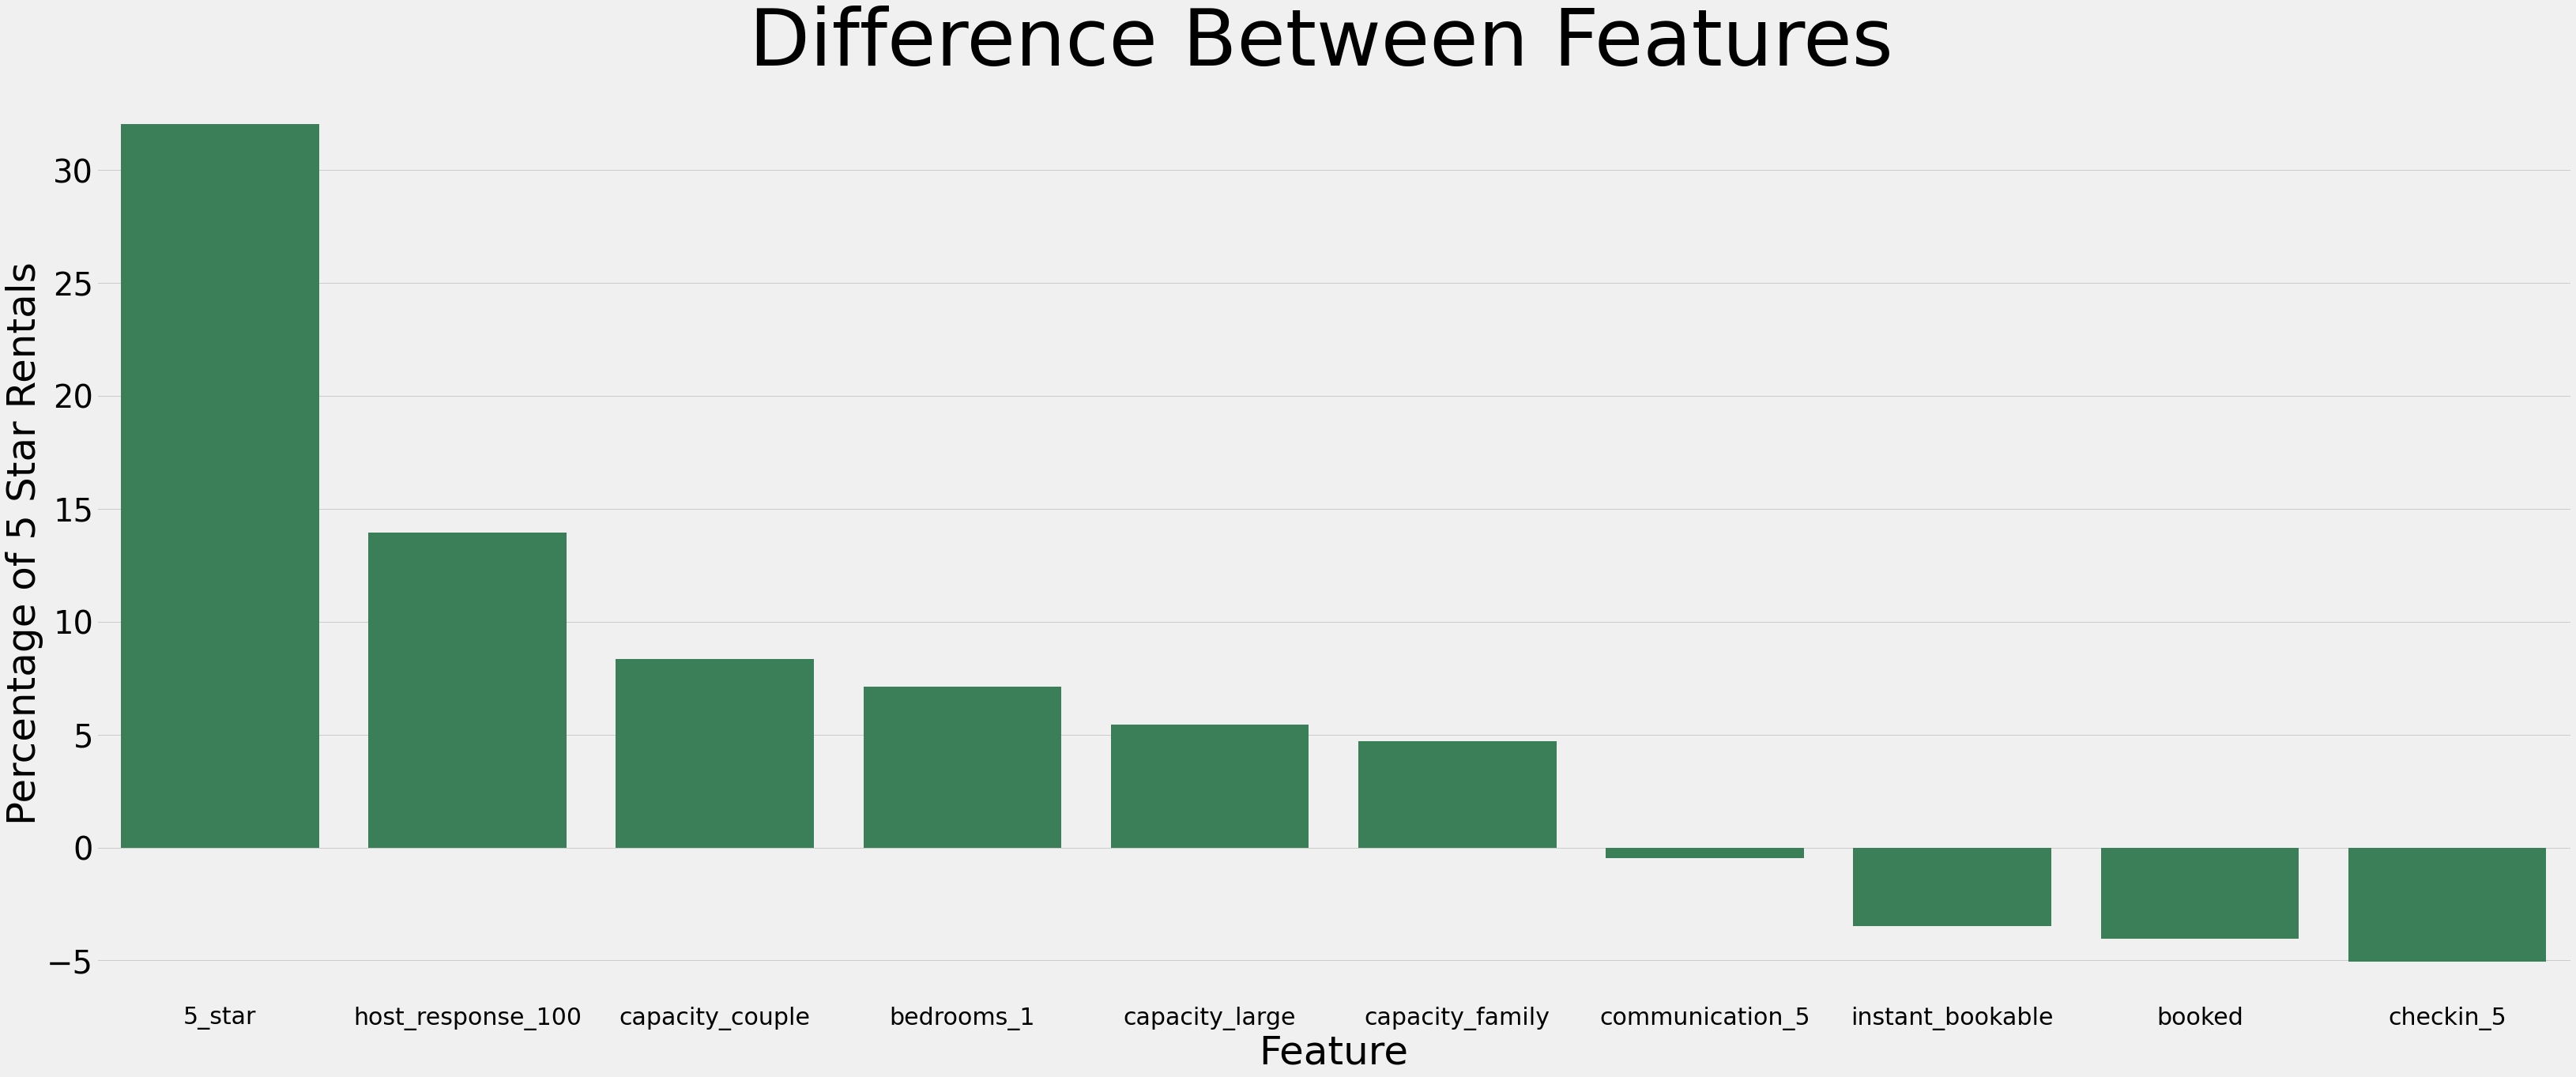

In [207]:
superhost_plot = plot_stats(superhost_stats)
superhost_plot

### <b> Top Feature #2: Accuracy </b>

In [208]:
accuracy_metrics = review_metrics.groupby('accuracy_5').sum()
accuracy_metrics

,5_star,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
accuracy_5,,,,,,,,,,,,,,,
False,3115,1102,490,1110,943,167,3127,2512,2885,1165,1418,332,3439,4282,2697
True,1803,1673,1339,1616,1433,1064,872,692,811,598,590,113,1214,1439,882


In [209]:
accuracy_stats = get_stats(accuracy_metrics)
accuracy_stats

accuracy_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,167,1064,1231,86.433794,13.566206,72.867587
2,cleanliness_5,490,1339,1829,73.209404,26.790596,46.418808
4,location_5,943,1433,2376,60.311448,39.688552,20.622896
1,communication_5,1102,1673,2775,60.288288,39.711712,20.576577
3,checkin_5,1110,1616,2726,59.280998,40.719002,18.561996
0,5_star,3115,1803,4918,36.661244,63.338756,-26.677511
9,booked,1165,598,1763,33.919455,66.080545,-32.161089
10,capacity_couple,1418,590,2008,29.382470,70.617530,-41.235060
12,capacity_large,3439,1214,4653,26.090694,73.909306,-47.818612
11,capacity_family,332,113,445,25.393258,74.606742,-49.213483


<b>Analysis:</b>
- The biggest difference between clients with a perfect accuracy score is that most also had a high <b> value</b> score. 
- The next biggest difference was cleanliness. 
- The next step down was communication, checking ,and location.
- Notably, clients with high accuracy scores are significantly less likely to be a superhost, have 5 or more listings, or utilize the instant book feature.

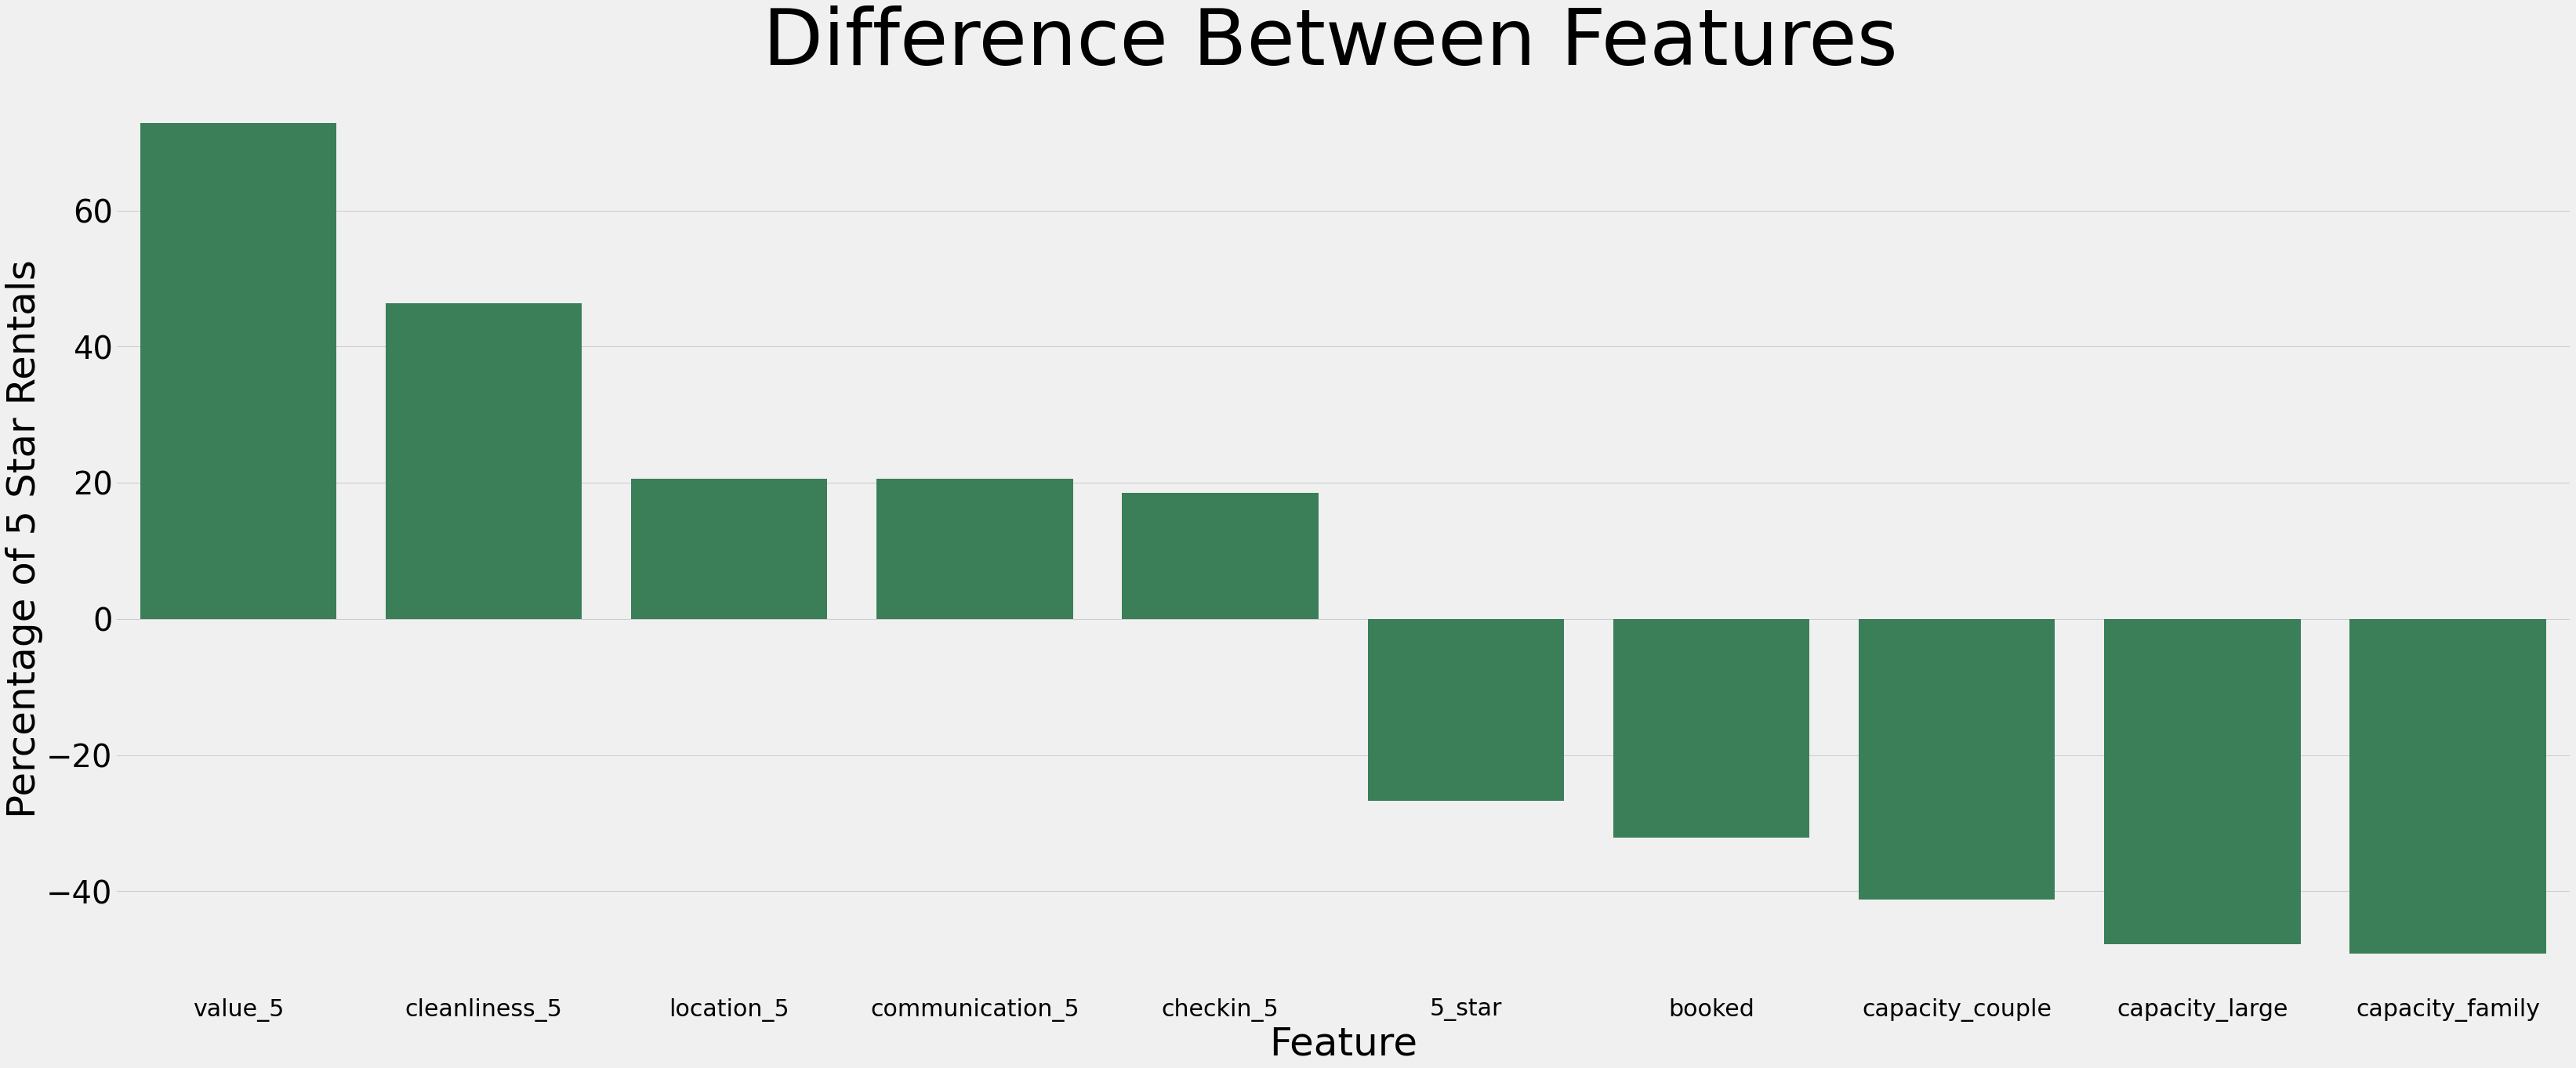

In [210]:
accuracy_plot = plot_stats(accuracy_stats)
accuracy_plot

### Value Stats

In [211]:
value_metrics = review_metrics.groupby('value_5').sum()
value_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
value_5,,,,,,,,,,,,,,,
False,3783,940,1658,854,1622,1340,3582,2786,3201,1379,1589,377,3872,4838,2991
True,1135,1064,1117,975,1104,1036,417,418,495,384,419,68,781,883,588


In [212]:
value_stats = get_stats(value_metrics)
value_stats

value_5,Metric,False,True,total,%_True,%_False,delta
3,cleanliness_5,854,975,1829,53.307818,46.692182,6.615637
1,accuracy_5,940,1064,2004,53.093812,46.906188,6.187625
5,location_5,1340,1036,2376,43.602694,56.397306,-12.794613
4,checkin_5,1622,1104,2726,40.498899,59.501101,-19.002201
2,communication_5,1658,1117,2775,40.252252,59.747748,-19.495495
0,5_star,3783,1135,4918,23.078487,76.921513,-53.843026
9,booked,1379,384,1763,21.781055,78.218945,-56.437890
10,capacity_couple,1589,419,2008,20.866534,79.133466,-58.266932
12,capacity_large,3872,781,4653,16.784870,83.215130,-66.430260
14,bedrooms_1,2991,588,3579,16.429170,83.570830,-67.141660


### Communication Stats

In [213]:
communication_metrics = review_metrics.groupby('communication_5').sum()
communication_metrics

,5_star,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
communication_5,,,,,,,,,,,,,,,
False,2587,331,359,615,680,114,2618,2256,2573,949,1225,281,3002,3643,2364
True,2331,1673,1470,2111,1696,1117,1381,948,1123,814,783,164,1651,2078,1215


In [214]:
communication_stats = get_stats(communication_metrics)
communication_stats

communication_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,114,1117,1231,90.739236,9.260764,81.478473
1,accuracy_5,331,1673,2004,83.483034,16.516966,66.966068
2,cleanliness_5,359,1470,1829,80.371788,19.628212,60.743576
3,checkin_5,615,2111,2726,77.439472,22.560528,54.878944
4,location_5,680,1696,2376,71.380471,28.619529,42.760943
0,5_star,2587,2331,4918,47.397316,52.602684,-5.205368
9,booked,949,814,1763,46.171299,53.828701,-7.657402
10,capacity_couple,1225,783,2008,38.994024,61.005976,-22.011952
11,capacity_family,281,164,445,36.853933,63.146067,-26.292135
13,host_response_100,3643,2078,5721,36.322321,63.677679,-27.355357


<b> analysis: </b>
- Clients that communicate well have significantly better value and accuracy scores than those who don't. 
- It's also noticeable that clients who scored high in communication had under 5 listings, and were less likely to use instant book for their property.
-- My assumption is that they prefer a more "hands on" approach and want to make sure that they are communicating directly to the person booking the property than having the process automated and unpersonalized.

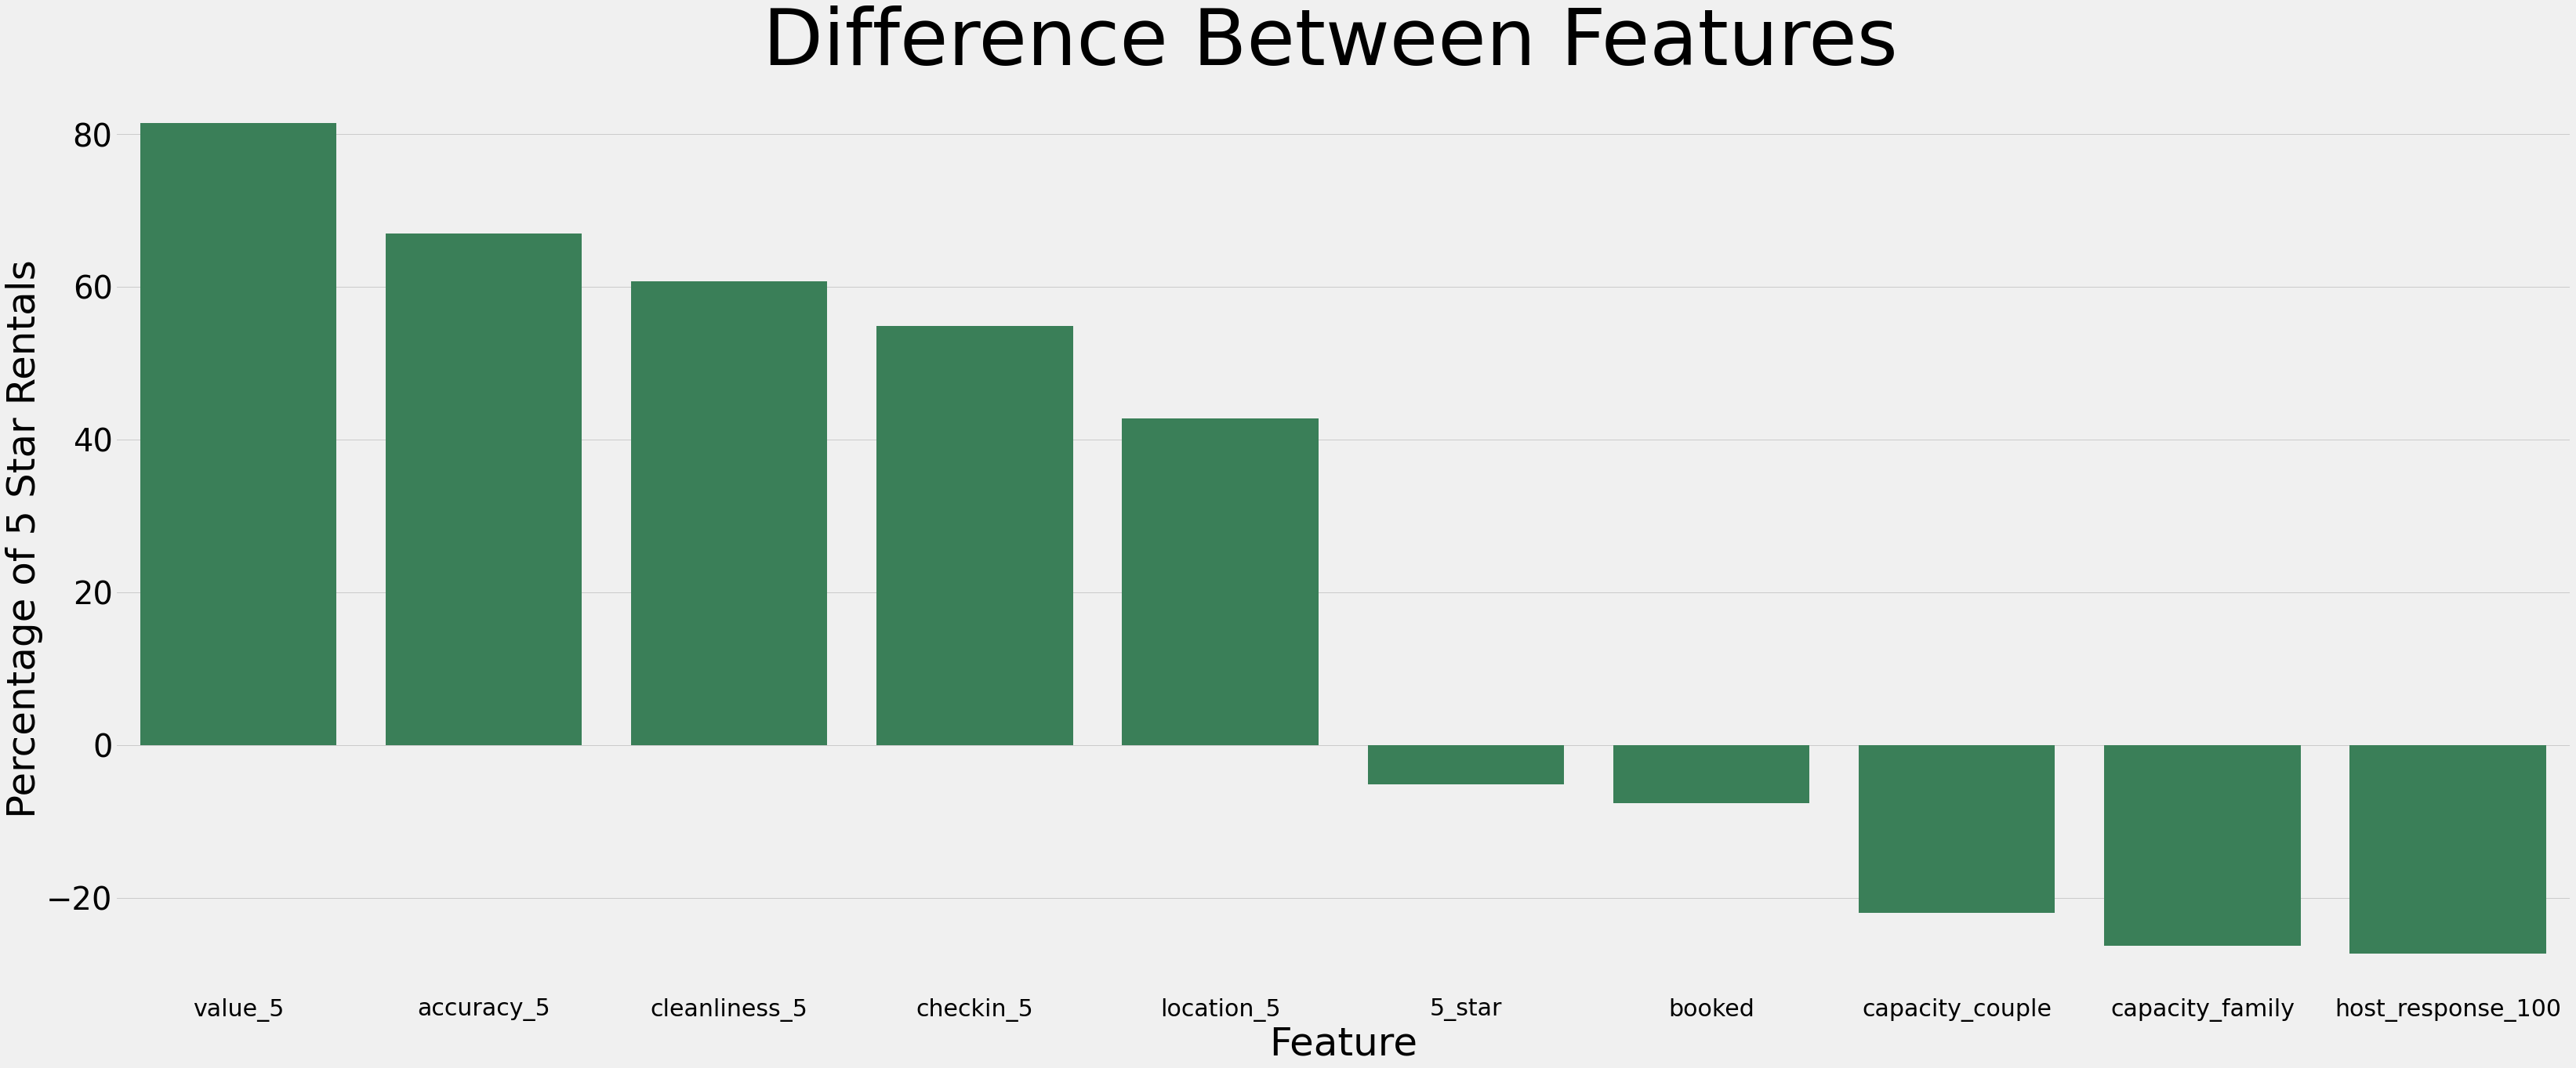

In [215]:
communication_plot = plot_stats(communication_stats)
communication_plot

### Cleanliness Stats

In [216]:
cleanliness_metrics = review_metrics.groupby('cleanliness_5').mean()
cleanliness_metrics

,5_star,accuracy_5,communication_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
cleanliness_5,,,,,,,,,,,,,,,
False,0.553419,0.111185,0.218191,0.212339,0.185420,0.042802,0.536031,0.422003,0.492225,0.208326,0.243103,0.058184,0.593881,0.738840,0.461628
True,0.879169,0.732094,0.803718,0.796063,0.692728,0.533078,0.433570,0.371788,0.411154,0.282668,0.302898,0.053034,0.601968,0.711864,0.447239


In [217]:
cleanliness_stats = get_stats(cleanliness_metrics)
cleanliness_stats

cleanliness_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,0.042802,0.533078,0.575880,92.567518,7.432482,85.135036
1,accuracy_5,0.111185,0.732094,0.843279,86.815116,13.184884,73.630232
3,checkin_5,0.212339,0.796063,1.008402,78.943024,21.056976,57.886048
4,location_5,0.185420,0.692728,0.878149,78.885070,21.114930,57.770140
2,communication_5,0.218191,0.803718,1.021909,78.648688,21.351312,57.297376
0,5_star,0.553419,0.879169,1.432588,61.369276,38.630724,22.738551
9,booked,0.208326,0.282668,0.490994,57.570529,42.429471,15.141057
10,capacity_couple,0.243103,0.302898,0.546001,55.475687,44.524313,10.951373
12,capacity_large,0.593881,0.601968,1.195849,50.338156,49.661844,0.676312
14,bedrooms_1,0.461628,0.447239,0.908867,49.208379,50.791621,-1.583241


### Analysis
- Clients that have a perfect cleanliness score score high in all the other review metrics, most notably Value, and Accuracy.
- However, the bigger factors are that they aren't likely to manage 5 or more listings, be instant bookable, or a superhost.
-- My assumption is that they can keep their rental(s) clean because they don't have more than they can handle, and they 

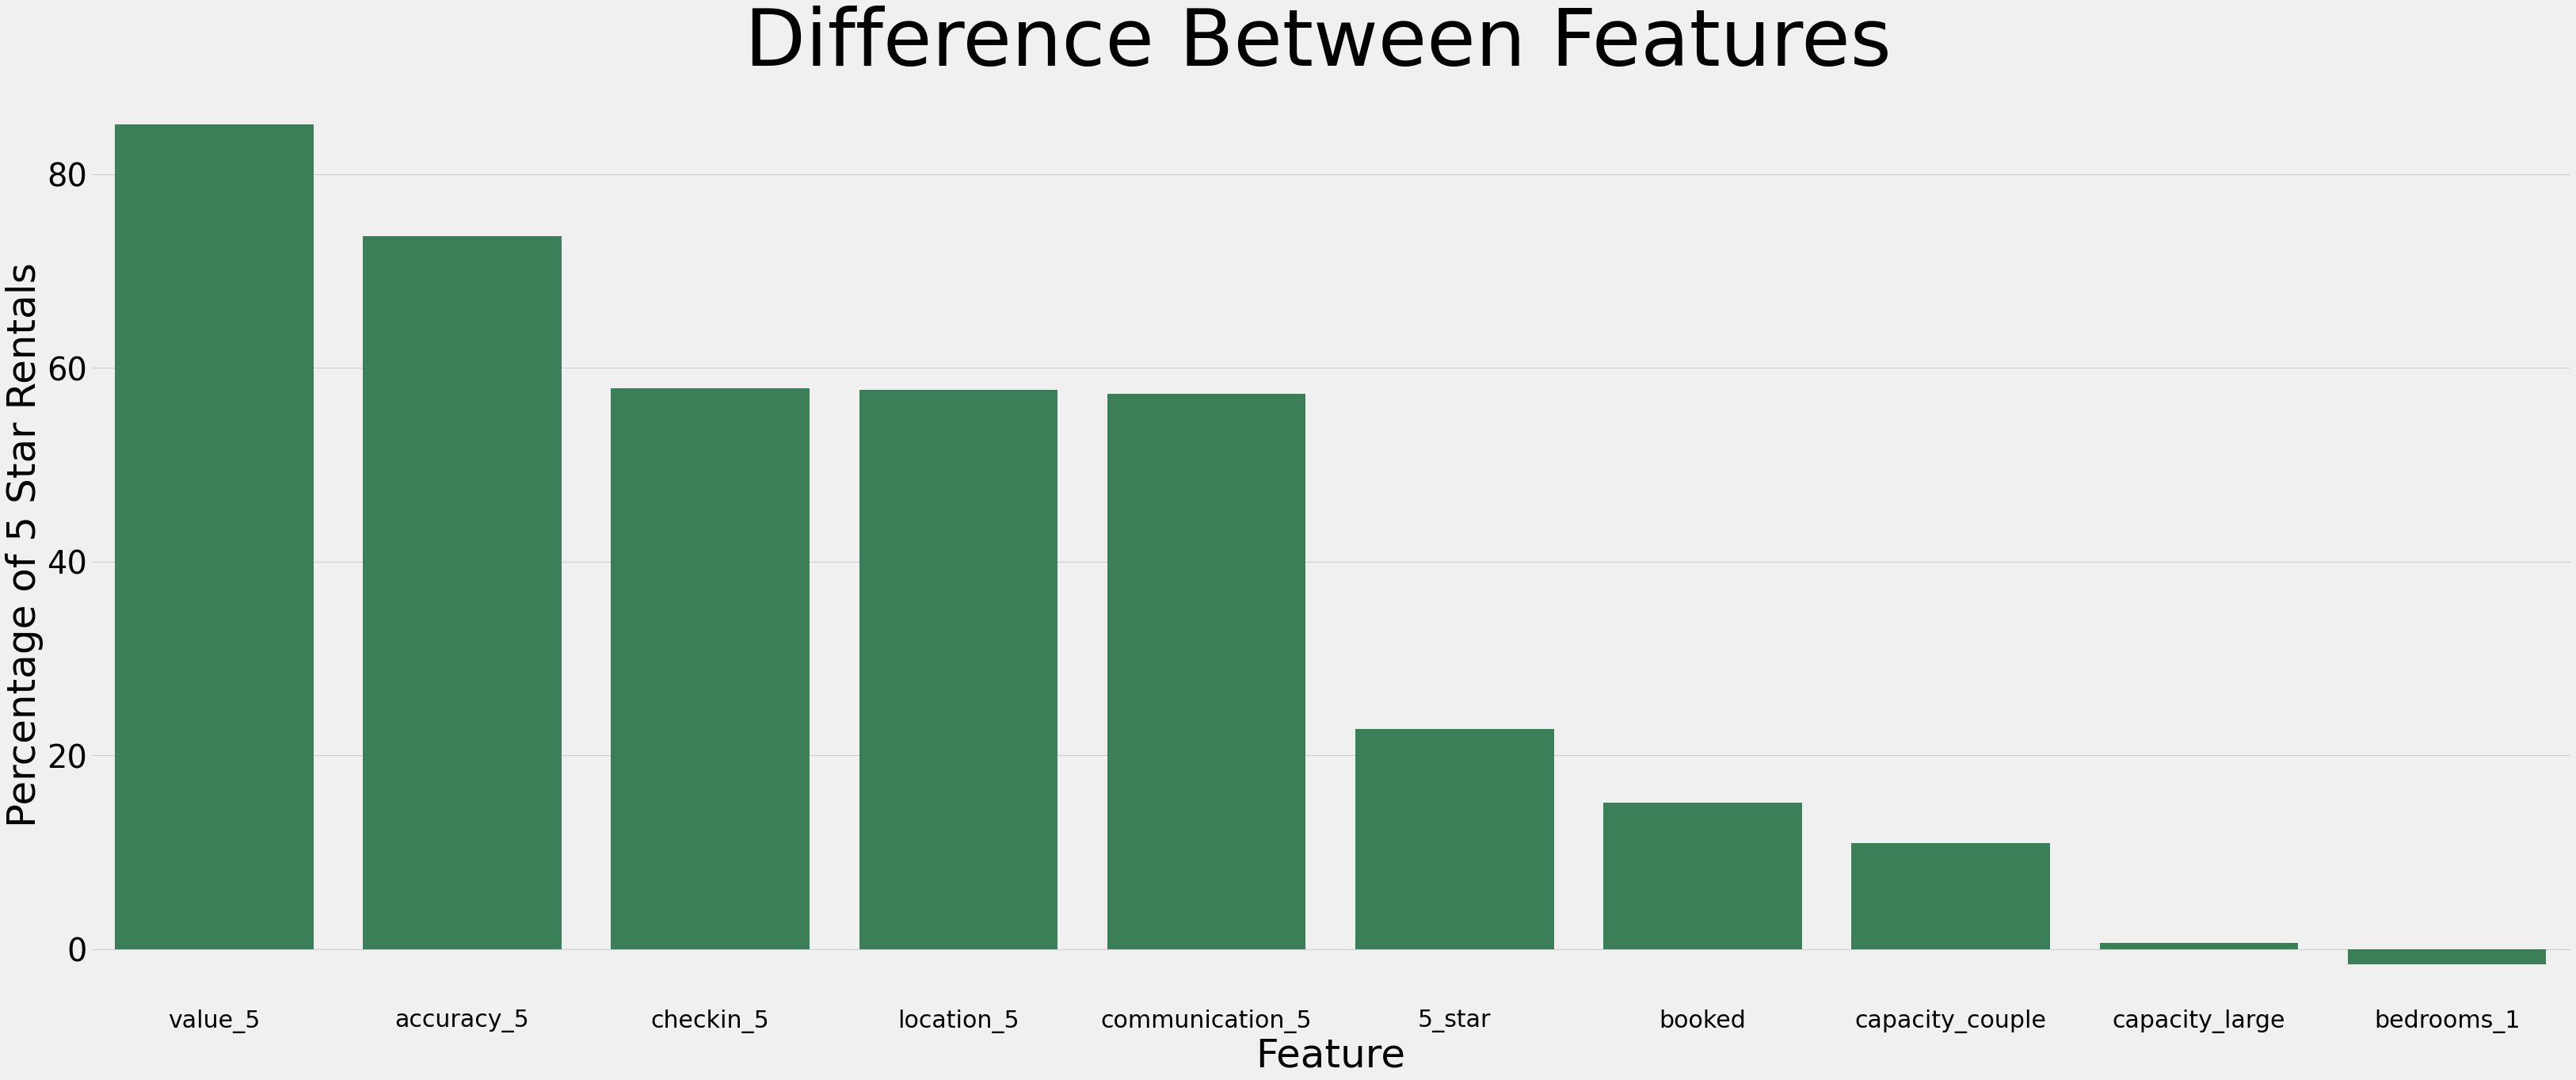

In [218]:
cleanliness_plot = plot_stats(cleanliness_stats)
cleanliness_plot

### <b> 5 Star Unit Stats </b>

In [219]:
review_analysis_df = review_metrics.groupby('5_star').sum()
review_analysis_df

,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
5_star,,,,,,,,,,,,,,,
False,201,444,221,488,520,96,752,1624,1642,592,575,158,1628,1852,1243
True,1803,2331,1608,2238,1856,1135,3247,1580,2054,1171,1433,287,3025,3869,2336


In [220]:
five_star_stats = get_stats(review_analysis_df)
five_star_stats

5_star,Metric,False,True,total,%_True,%_False,delta
5,value_5,96,1135,1231,92.201462,7.798538,84.402924
0,accuracy_5,201,1803,2004,89.970060,10.029940,79.940120
2,cleanliness_5,221,1608,1829,87.916894,12.083106,75.833789
1,communication_5,444,2331,2775,84.000000,16.000000,68.000000
3,checkin_5,488,2238,2726,82.098313,17.901687,64.196625
6,superhost,752,3247,3999,81.195299,18.804701,62.390598
4,location_5,520,1856,2376,78.114478,21.885522,56.228956
10,capacity_couple,575,1433,2008,71.364542,28.635458,42.729084
13,host_response_100,1852,3869,5721,67.628037,32.371963,35.256074
9,booked,592,1171,1763,66.420874,33.579126,32.841747


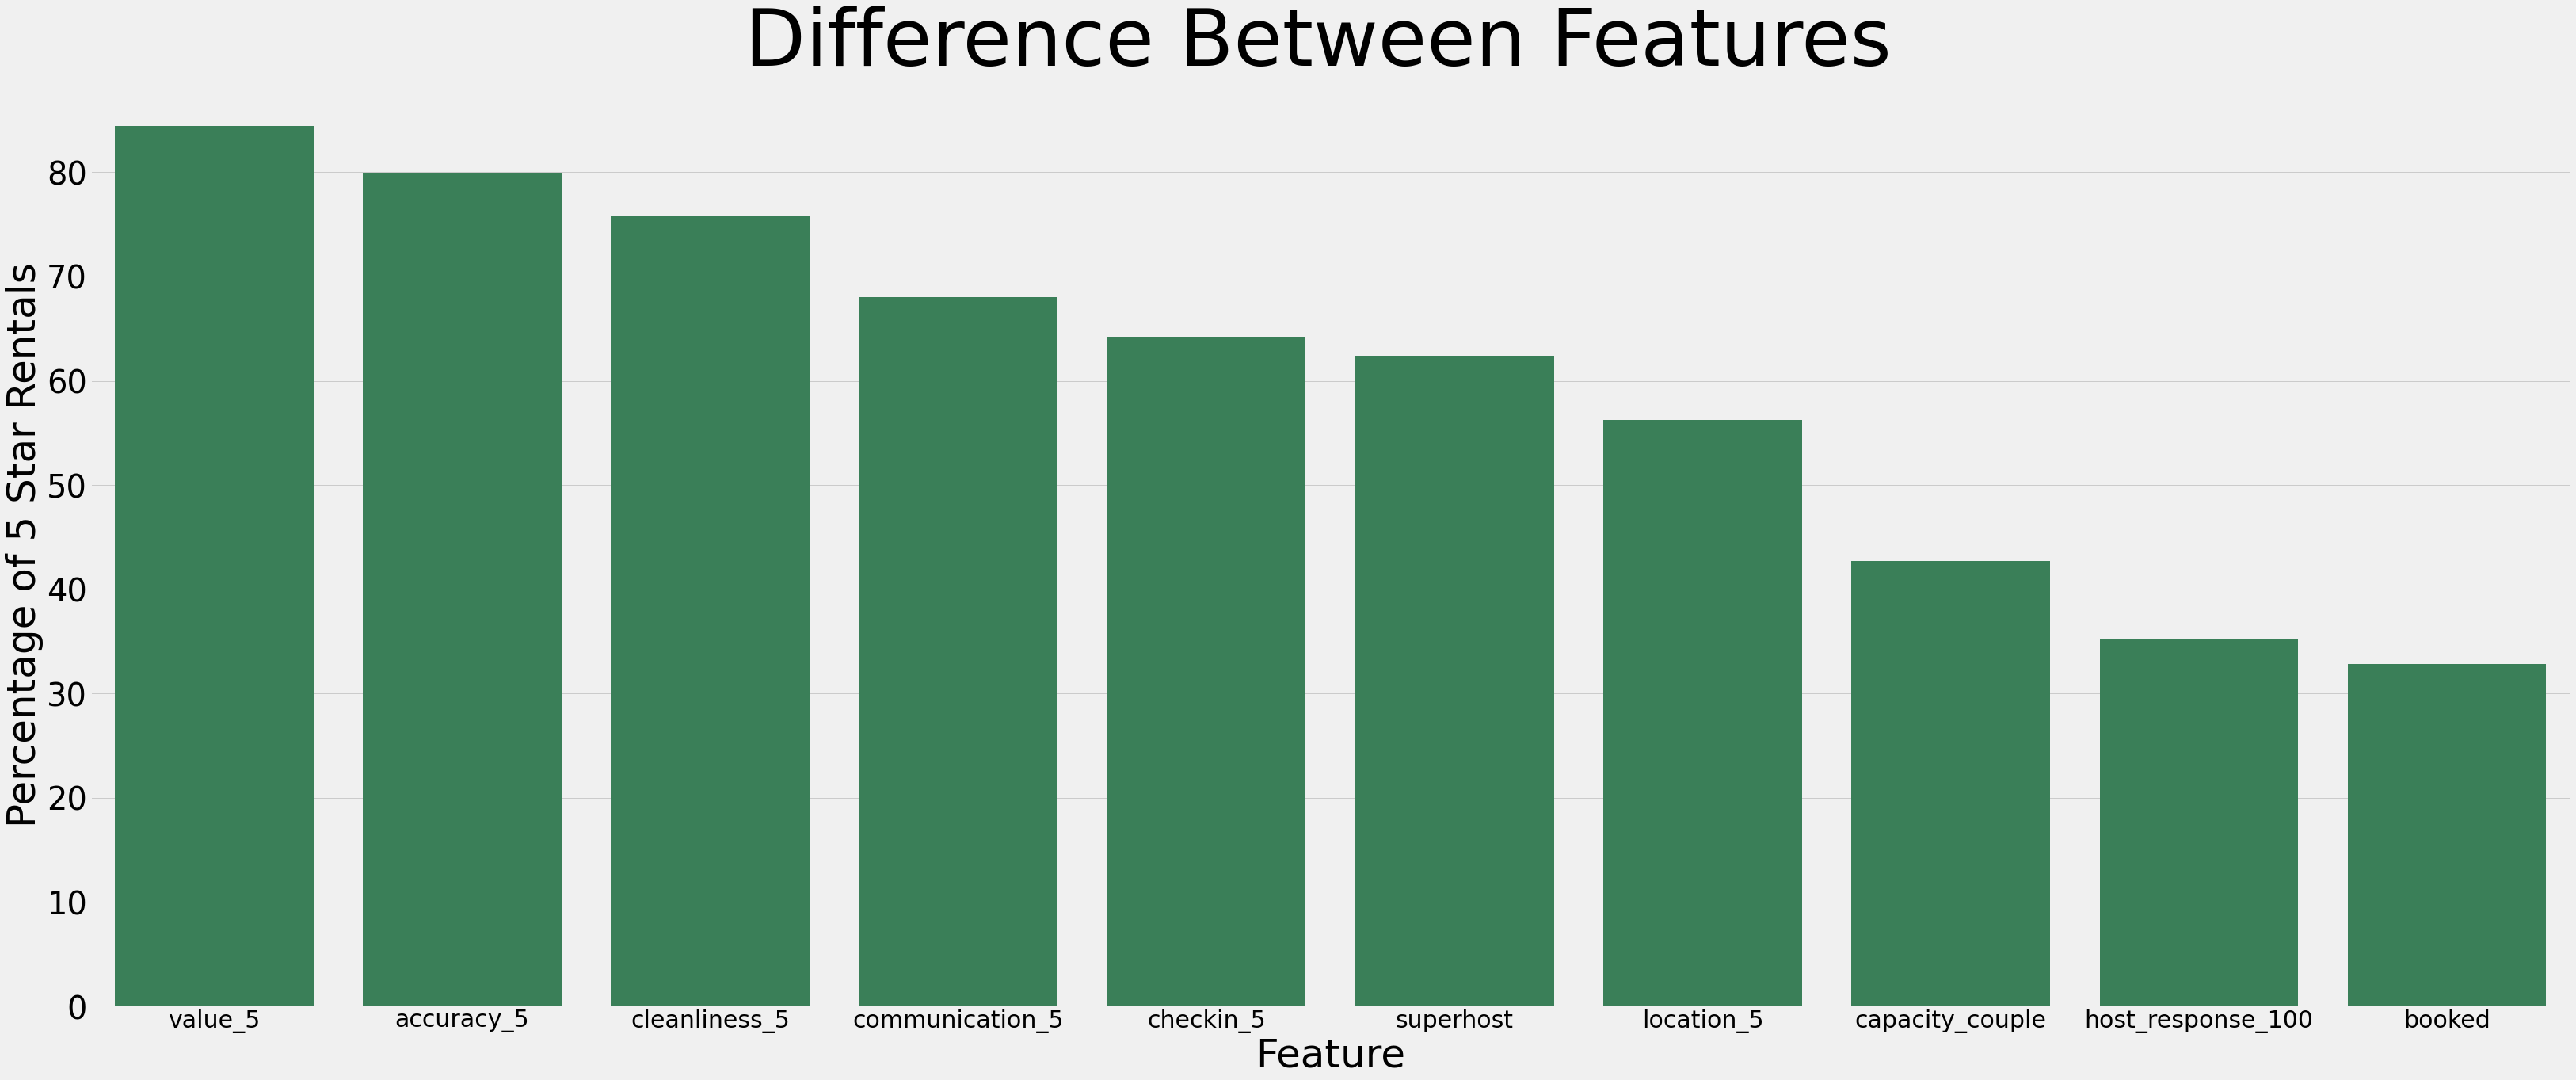

In [221]:
five_star_plot = plot_stats(five_star_stats)
five_star_plot

### Instant Bookable Stats

In [222]:
instant_book_metrics = review_metrics.groupby('instant_bookable').sum()
instant_book_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
instant_bookable,,,,,,,,,,,,,,,
False,2864,1193,1652,1077,1611,1323,736,2215,1172,1137,1325,264,2673,3136,2042
True,2054,811,1123,752,1115,1053,495,1784,2032,626,683,181,1980,2585,1537


In [223]:
instant_book_stats = get_stats(instant_book_metrics)
instant_book_stats

instant_bookable,Metric,False,True,total,%_True,%_False,delta
8,host_listings_5+,1172,2032,3204,63.420724,36.579276,26.841448
13,host_response_100,3136,2585,5721,45.184408,54.815592,-9.631183
7,superhost,2215,1784,3999,44.611153,55.388847,-10.777694
5,location_5,1323,1053,2376,44.318182,55.681818,-11.363636
14,bedrooms_1,2042,1537,3579,42.944957,57.055043,-14.110087
12,capacity_large,2673,1980,4653,42.553191,57.446809,-14.893617
0,5_star,2864,2054,4918,41.764945,58.235055,-16.470110
3,cleanliness_5,1077,752,1829,41.115364,58.884636,-17.769273
4,checkin_5,1611,1115,2726,40.902421,59.097579,-18.195158
11,capacity_family,264,181,445,40.674157,59.325843,-18.651685


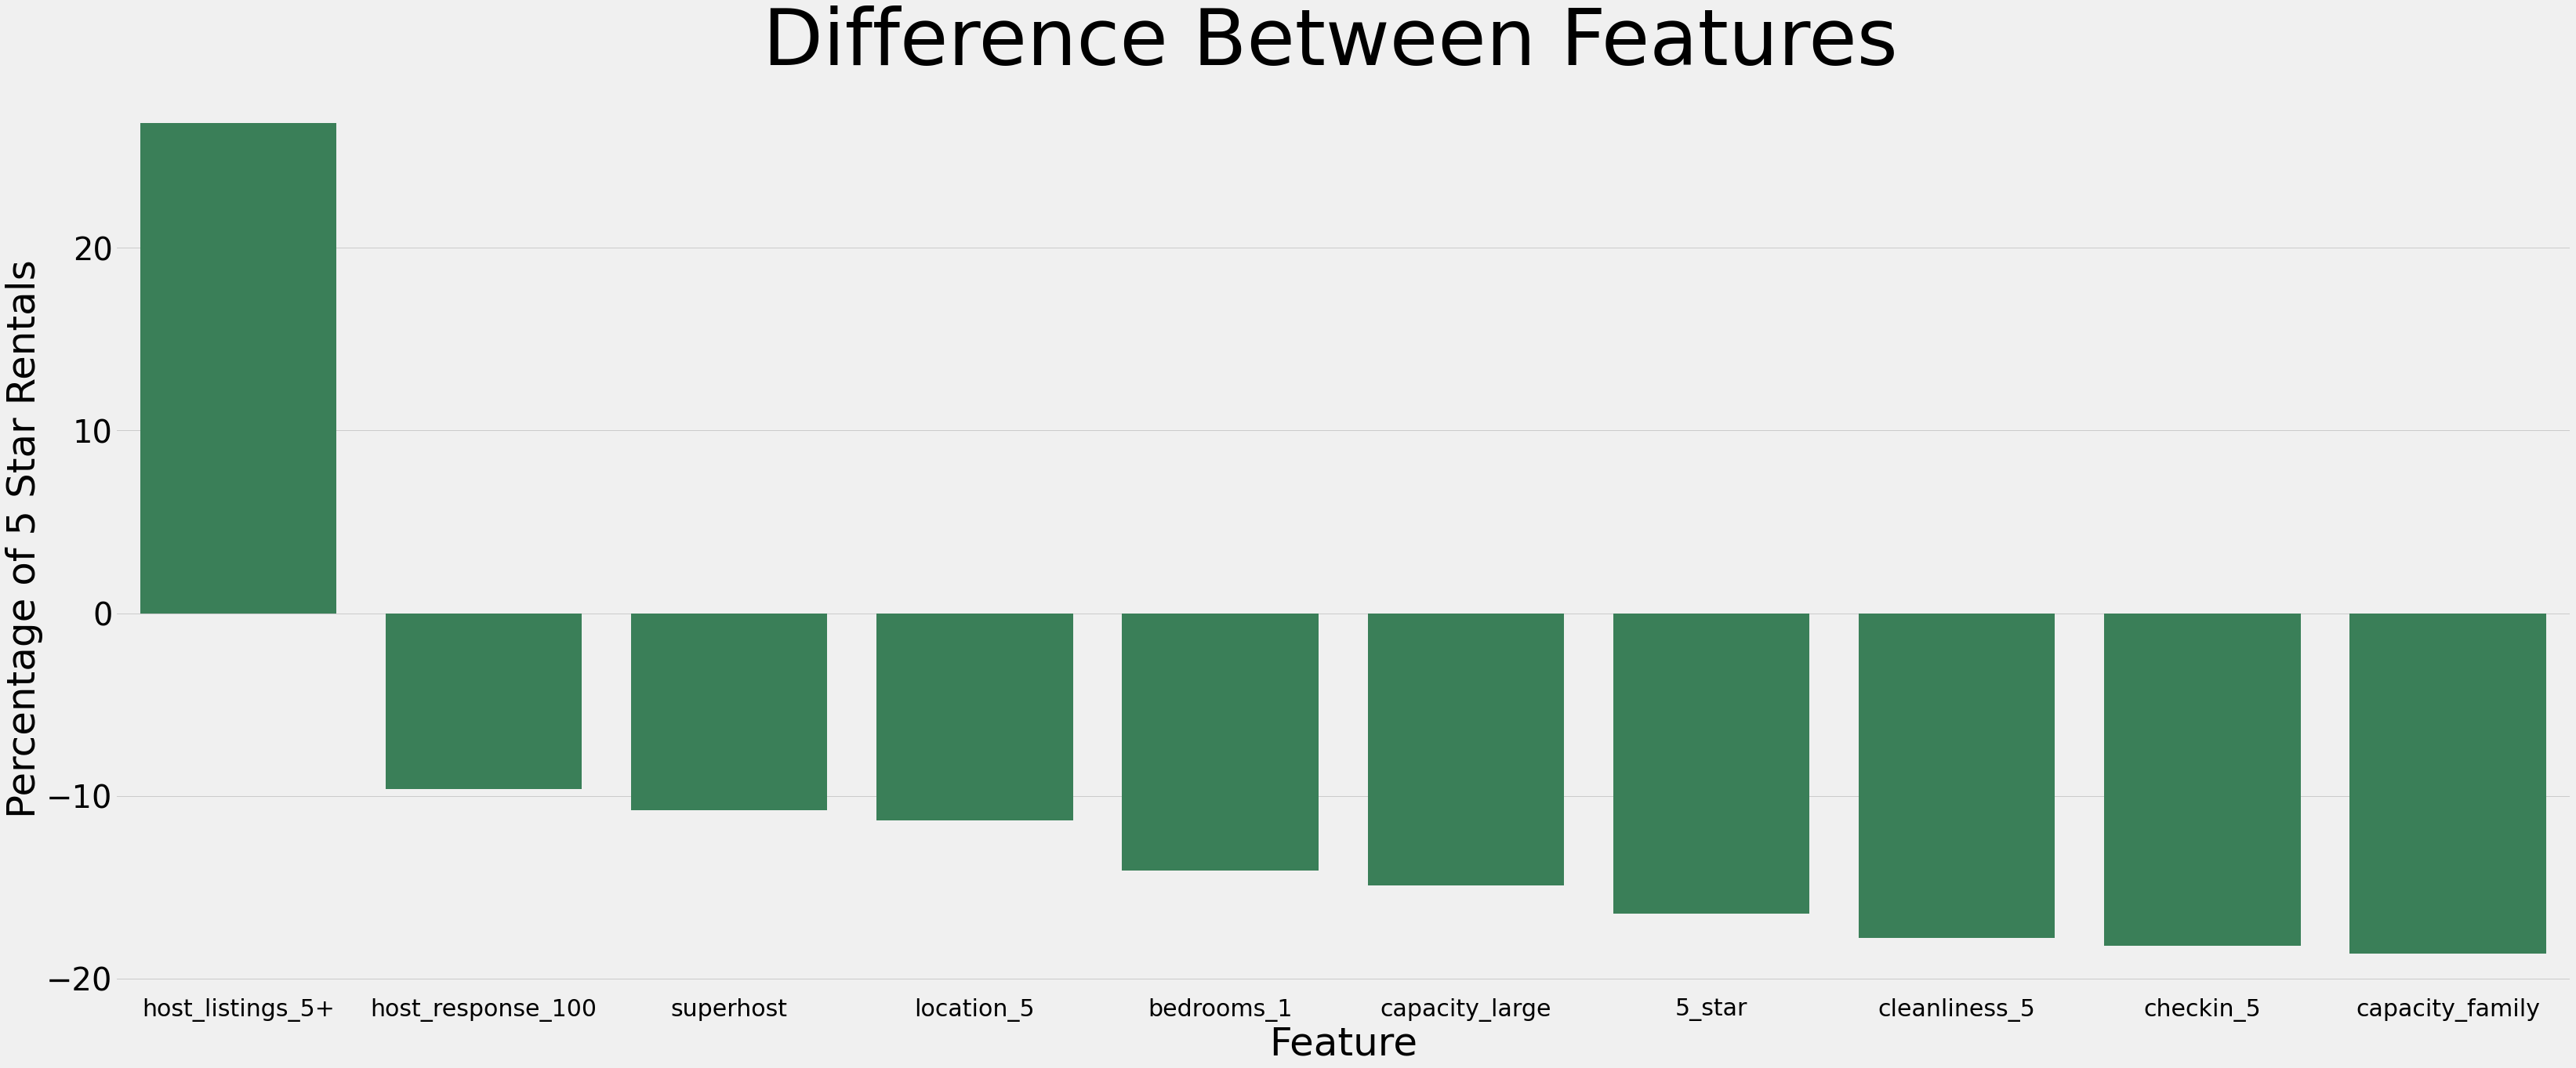

In [224]:
instant_book_plot = plot_stats(instant_book_stats)
instant_book_plot

### Booked Stats

In [225]:
booked_metrics = review_metrics.groupby('booked').sum()
booked_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5+,instant_bookable,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
booked,,,,,,,,,,,,,,,
False,3747,1406,1961,1312,1913,1730,847,3153,2684,3070,1388,328,3427,4408,2665
True,1171,598,814,517,813,646,384,846,520,626,620,117,1226,1313,914


In [226]:
booked_stats = get_stats(booked_metrics)
booked_stats

booked,Metric,False,True,total,%_True,%_False,delta
6,value_5,847,384,1231,31.194151,68.805849,-37.611698
10,capacity_couple,1388,620,2008,30.876494,69.123506,-38.247012
1,accuracy_5,1406,598,2004,29.840319,70.159681,-40.319361
4,checkin_5,1913,813,2726,29.823918,70.176082,-40.352164
2,communication_5,1961,814,2775,29.333333,70.666667,-41.333333
3,cleanliness_5,1312,517,1829,28.266812,71.733188,-43.466375
5,location_5,1730,646,2376,27.188552,72.811448,-45.622896
12,capacity_large,3427,1226,4653,26.348592,73.651408,-47.302815
11,capacity_family,328,117,445,26.292135,73.707865,-47.415730
14,bedrooms_1,2665,914,3579,25.537860,74.462140,-48.924281


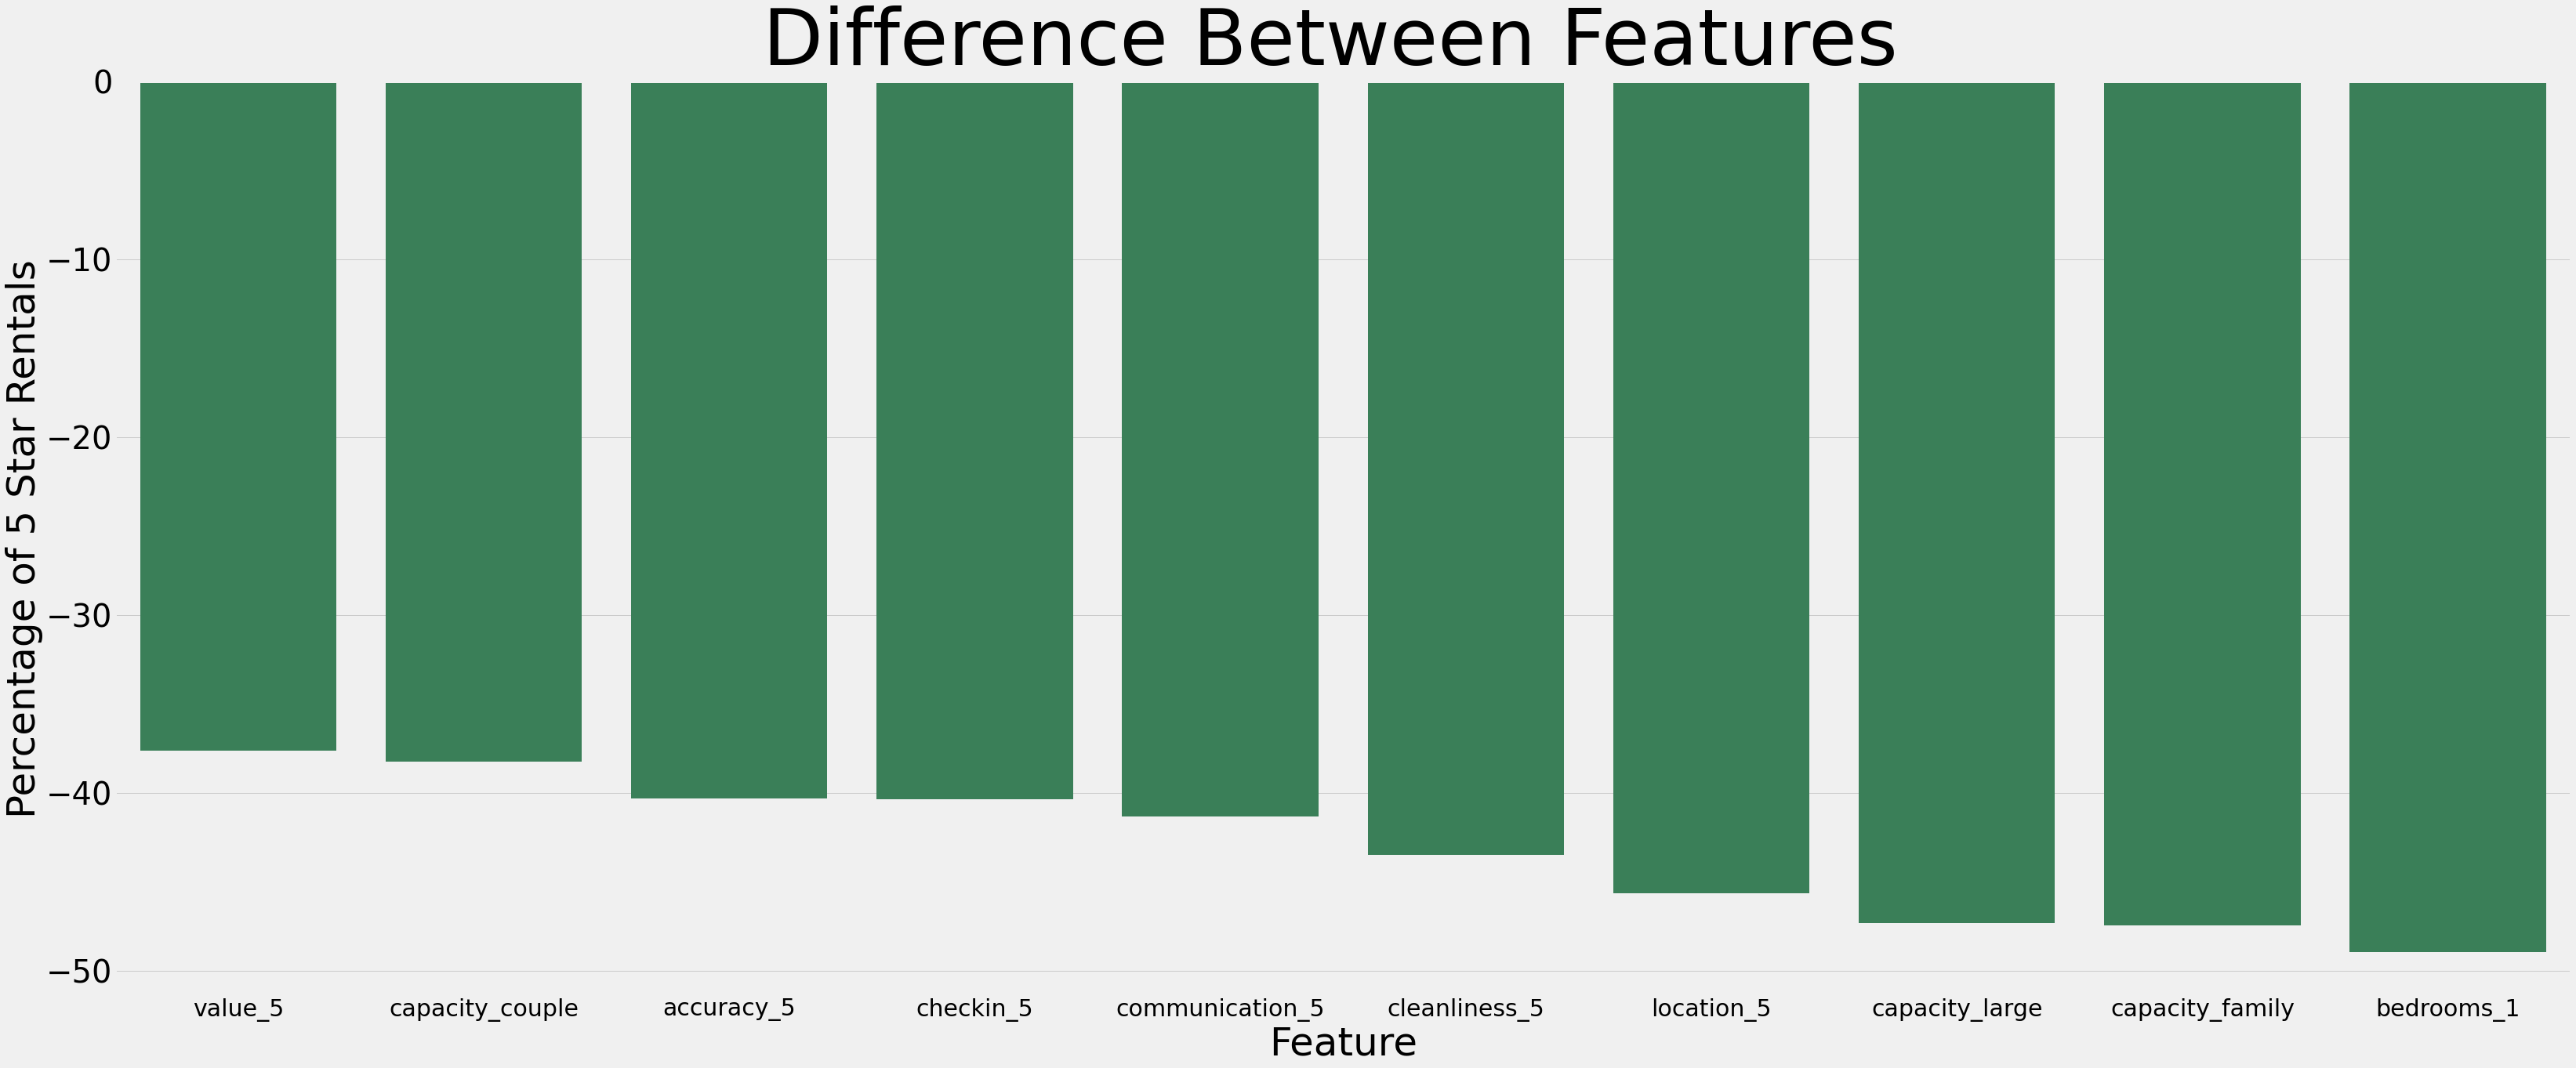

In [227]:
booked_plot = plot_stats(booked_stats)
booked_plot

### Listing 5+ Stats

In [236]:
host_listing_metrics = review_metrics.groupby('host_listings_5+').sum()
host_listing_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,instant_bookable,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1
host_listings_5+,,,,,,,,,,,,,,,
False,3338,1312,1827,1149,1782,1340,813,2623,1664,1243,1553,308,3089,3854,2364
True,1580,692,948,680,944,1036,418,1376,2032,520,455,137,1564,1867,1215


In [237]:
get_stats(host_listing_metrics)

host_listings_5+,Metric,False,True,total,%_True,%_False,delta
8,instant_bookable,1664,2032,3696,54.978355,45.021645,9.956710
5,location_5,1340,1036,2376,43.602694,56.397306,-12.794613
3,cleanliness_5,1149,680,1829,37.178786,62.821214,-25.642428
4,checkin_5,1782,944,2726,34.629494,65.370506,-30.741012
1,accuracy_5,1312,692,2004,34.530938,65.469062,-30.938124
7,superhost,2623,1376,3999,34.408602,65.591398,-31.182796
2,communication_5,1827,948,2775,34.162162,65.837838,-31.675676
6,value_5,813,418,1231,33.956133,66.043867,-32.087734
14,bedrooms_1,2364,1215,3579,33.948030,66.051970,-32.103940
12,capacity_large,3089,1564,4653,33.612723,66.387277,-32.774554


In [228]:
booked_df = cleaned_df[cleaned_df['booked_True'] == True]

In [229]:
booked_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,capacity_couple_True,capacity_family_True,capacity_large_True,host_listings_5+_True,superhost_True,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,...,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,0.664209,0.339195,0.293250,0.461146,0.366421,0.217811,0.461713,0.769711,0.225752,0.004538,...,0.351673,0.066364,0.695406,0.294952,0.479864,0.744753,0.045377,0.107771,0.176404,0.670448
std,0.472400,0.473570,0.455381,0.498629,0.481963,0.412875,0.498673,0.421137,0.418195,0.067229,...,0.477628,0.248988,0.460366,0.456150,0.499736,0.436124,0.208189,0.310179,0.381272,0.470184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Attempting Master LinePlot

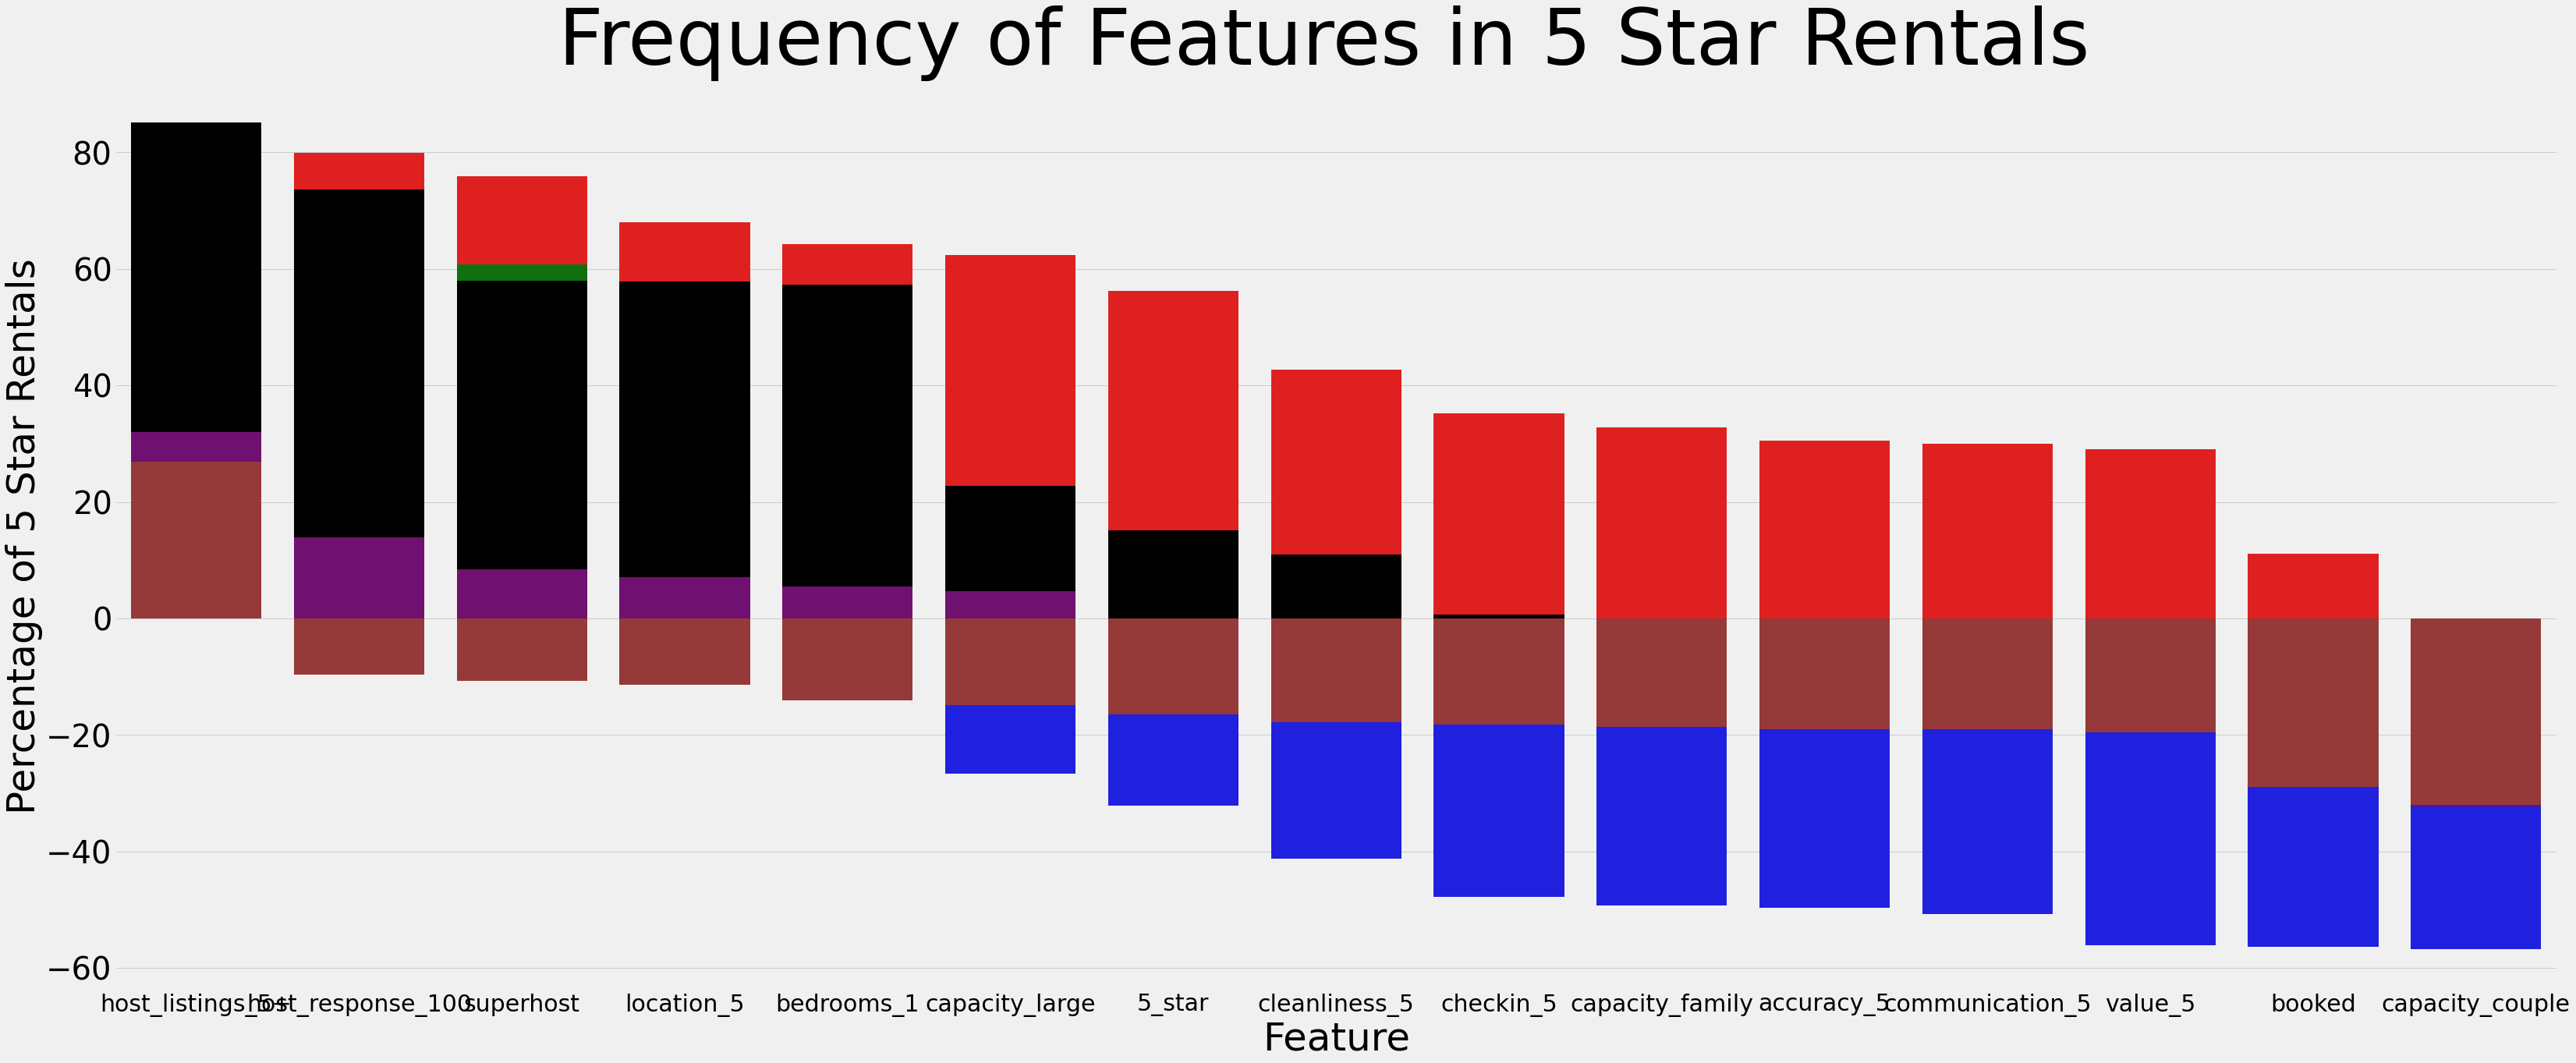

In [233]:
fig, ax = plt.subplots(figsize=(50,20))


p = sns.barplot(data=five_star_stats, x='Metric', y='delta', color ='red' );
p = sns.barplot(data=communication_stats, x='Metric', y='delta', color ='green' );
p = sns.barplot(data=accuracy_stats, x='Metric', y='delta', color ='blue' );
p = sns.barplot(data=cleanliness_stats, x='Metric', y='delta', color ='black' );
p = sns.barplot(data=superhost_stats, x='Metric', y='delta', color ='purple' );
p = sns.barplot(data=instant_book_stats, x='Metric', y='delta', color ='brown' );




p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### Analysis:
    - Even a small drop in accuracy results in a drop in the review score rating.

## Analysis of Review Metrics

In [ ]:
review_metrics

### Analysis:
- Units with a perfect accuracy rating were 72% more likely to have a perfect overall rating.
- Units with a perfect cleanliness rating were 64% more likely to have a perfect overall rating.
- Units with a perfect checkin rating were 63% more likely to have a perfect overall rating.
- Units with a perfect location rating were 58% more likely to have a perfect overall rating.
- Units with a perfect value rating were 56% more likely to have a perfect overall rating.


## Conclusion

## Further Work